# Geometric and Topological Methods in Machine Learning Project 2022-2023


Student: **Ufuk Cem Birbiri**

ufuk-cem.birbiri@etu.univ-cotedazur.fr

Data Science & AI MSc - M2

Université Côte d'Azur

In this project, we analyze the single-cell Hi-C contact maps using Topological data analysis. A Hi-C contact map is a pairwise distance matrix that encodes how chromatin is folded in the nucleus of a cell: each row and column of the matrix represents a small DNA window, and each entry in the matrix is the spatial distance between these windows in the nucleus.

[The dataset](http://www-sop.inria.fr/abs/teaching/centrale-FGMDA/exam_mathieu/schic.zip) contains 1171 contact maps with the shape (5234, 5234). We will first load the data and extract contact maps, then calculate the Stratum-adjusted correlation coefficient (SCC) between each contact map and visualize it with the Mapper algorithm. I loaded the data to my Drive, then used Google Colab in this work therefore data loading and preprocessing are done according to the Colab environment: loading the data from Google Drive and saving the results there. Each step is explained below.
 

#1. Load the data

In [2]:
#Connect the Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load an example Hi-C map.

In [3]:
import numpy as np
import scipy.sparse
import networkx as nx


contact_map = scipy.sparse.load_npz('/content/drive/MyDrive/Geometric_methods_PROJECT/schic/processed/1CDX1.395/cmatrix_500k.npz')
contact_map= contact_map.toarray()
contact_map.shape, type(contact_map)

((5234, 5234), numpy.ndarray)

In [4]:
contact_map

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

The contact maps' shape is (5234, 5234). If you run the following cell, you can see the graph representation of the contact map. (It takes a while to give the result so I attached the visualization result). The graph representation of the example Hi-C contact map seems a sparse graph. There are many zeros in the matrix so maybe it is reasonable to be sparse. 

In [5]:
from matplotlib import pyplot as plt

#Visualize the Hi-C contact map as a graph.
G = nx.from_numpy_array(contact_map)
#plt.figure()
#nx.draw(G)
#plt.show()

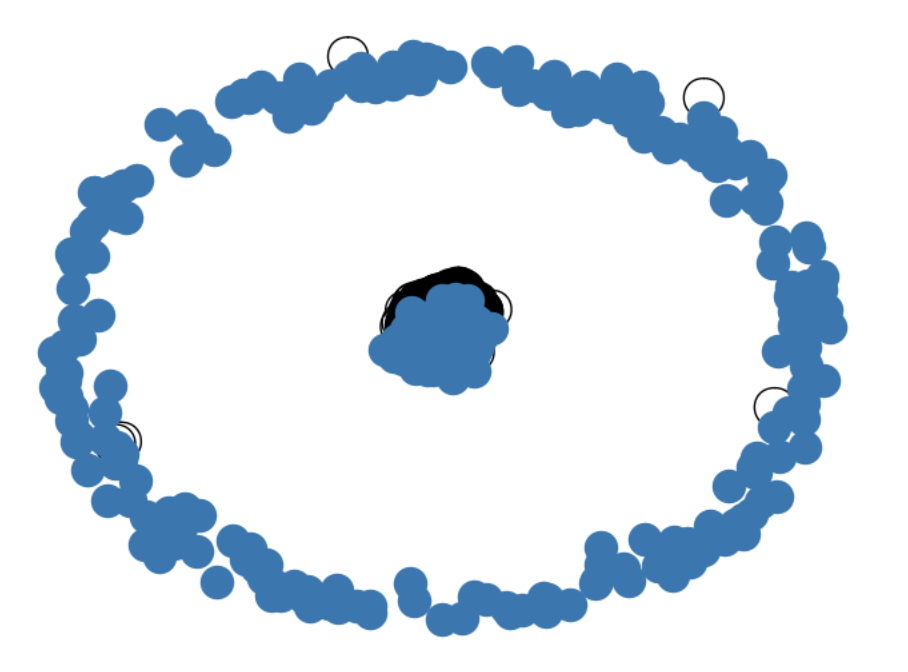

Now we read all the contact maps and rename them. Since the contacts maps have un-ordered names such as 1CDX3.56, 1CDX2.488, and 1CDX1.222, I loaded them from Drive, rename them in numeric values(ex: 1, 2, 3, ...), and loaded them to Drive again. The reason for renaming is to access and read them easily. The following cell does this job.

In [6]:
import os
import numpy as np
import scipy.sparse
import networkx as nx

#rootdir = './schic/processed/'
rootdir = "/content/drive/MyDrive/Geometric_methods_PROJECT/schic/processed/"
subsample = 0

file_count =0
contact_map_names = []

#Read the contact maps:
for file in os.listdir(rootdir,):
    contact_map = os.path.join(rootdir, file)
    if os.path.isdir(contact_map):

        #Save the file names:
        names= contact_map.split("/")[-1]
        contact_map_names.append(names)
        

        ##########################################
        #Path of the each contact map:
        print(contact_map+'/cmatrix_500k.npz')
        file_count+=1
       
        #Read the contact maps:
        #sparse_matrix = scipy.sparse.load_npz(d+'/cmatrix_500k.npz')

        #Save the renamed contact maps:
        #np.savetxt('/content/drive/MyDrive/Geometric_methods_PROJECT/contact_maps/'+str(file_count), sparse_matrix.toarray(), fmt='%d')



/content/drive/MyDrive/Geometric_methods_PROJECT/schic/processed/1CDX2.56/cmatrix_500k.npz
/content/drive/MyDrive/Geometric_methods_PROJECT/schic/processed/1CDX1.85/cmatrix_500k.npz
/content/drive/MyDrive/Geometric_methods_PROJECT/schic/processed/1CDX1.136/cmatrix_500k.npz
/content/drive/MyDrive/Geometric_methods_PROJECT/schic/processed/1CDX2.101/cmatrix_500k.npz
/content/drive/MyDrive/Geometric_methods_PROJECT/schic/processed/1CDX4.474/cmatrix_500k.npz
/content/drive/MyDrive/Geometric_methods_PROJECT/schic/processed/1CDX2.333/cmatrix_500k.npz
/content/drive/MyDrive/Geometric_methods_PROJECT/schic/processed/1CDX3.358/cmatrix_500k.npz
/content/drive/MyDrive/Geometric_methods_PROJECT/schic/processed/1CDX1.71/cmatrix_500k.npz
/content/drive/MyDrive/Geometric_methods_PROJECT/schic/processed/1CDX1.304/cmatrix_500k.npz
/content/drive/MyDrive/Geometric_methods_PROJECT/schic/processed/1CDX4.222/cmatrix_500k.npz
/content/drive/MyDrive/Geometric_methods_PROJECT/schic/processed/1CDX3.155/cmatrix_

In [7]:
print("There are ", len(contact_map_names), "Hi-C contact maps in total in the dataset.")  

There are  1171 Hi-C contact maps in total in the dataset.


#2 Calculate the SCC

##2.1 Implement the SCC function

In this part, the Stratum-adjusted correlation coefficient (SCC) function was implemented. This function takes two Hi-C contact maps and measures the SCC value between them. SCC value calculation code was adopted from the [Tao Yang's GitHub page](https://github.com/TaoYang-dev/hicrep). This code belongs to the ["HiCRep: assessing the reproducibility of Hi-C data using a stratum-adjusted correlation coefficient" paper](https://pubmed.ncbi.nlm.nih.gov/28855260/). The original code is written in R. I converted it to Python and optimized it. 



There are 1171 contacts maps in total and each has a shape of (5234, 5234), which means the dataset is huge. It takes a lot of time to calculate the SCC score between two matrices(also Google Colab provides limited computation power). I couldn't calculate the whole 1171 contact maps' SCC score so I needed to subsample it to 120. The get_scc function firstly smoothes the matrices with a moving average window of size 5 and computed all pairwise SCC values between contact matrices to generate a 120 x 120 similarity matrix. 

In [2]:
import numpy as np
from scipy.ndimage import convolve

#Smoothing function
def fastMeanFilter(matrix, h):
    kernel = np.ones((h, h), dtype=float) / h ** 2
    return convolve(matrix, kernel, mode='nearest')

def vstran(matrix):
    return np.array([matrix[:, 0] - matrix[:, 1], (matrix[:, 0] + matrix[:, 1]) / 2]).T

def get_scc(mat1, mat2, resol, h, lbr=0, ubr=5000000):
    if h == 0:
        smt_R1 = mat1
        smt_R2 = mat2
    else:
        smt_R1 = fastMeanFilter(mat1, h)
        smt_R2 = fastMeanFilter(mat2, h)


    lb = int(np.floor(lbr / resol))
    ub = int(np.floor(ubr / resol))
    corr = np.zeros(ub - lb + 1)
    cov = np.zeros(ub - lb + 1)
    wei = np.zeros(ub - lb + 1)
    n = np.zeros(ub - lb + 1)

    def est_scc(dist):
        #print("dist = ",dist,"\n")
        nonlocal corr, cov, wei, n
        ffd1 = []
        ffd2 = []
        ncols = smt_R1.shape[1]
        
        ffd1 = np.diagonal(smt_R1, offset=dist)
        ffd2 = np.diagonal(smt_R2, offset=dist)
        filt = np.where((ffd1 == 0) & (ffd2 == 0))[0]
        if len(filt) == 0:
            ffd = np.column_stack((ffd1, ffd2))
        else:
            ffd = np.column_stack((np.delete(ffd1, filt), np.delete(ffd2, filt)))
       
        if len(ffd) != 0:
            n = len(ffd)
            nd = vstran(ffd)
            if (len(np.unique(ffd[:, 0])) != 1) and (len(np.unique(ffd[:, 1])) != 1):
                corr = np.corrcoef(ffd[:, 0], ffd[:, 1])[0][1]
                cov = np.cov(nd[:, 0], nd[:, 1])[0][1]
                wei = np.sqrt(np.var(nd[:, 0]) * np.var(nd[:, 1])) * n
            else:
                corr = np.nan
                cov = np.nan
                wei = np.nan
        else:
            corr = np.nan
            cov = np.nan
            wei = np.nan
        return corr, wei

    st = np.array([est_scc(dist) for dist in range(lb, ub + 1)]).T
    corr0 = st[0]
    wei0 = st[1]
    corr = corr0[~np.isnan(corr0)]
    wei = wei0[~np.isnan(wei0)]
    scc = np.sum(corr * wei) / np.sum(wei)
    std = np.sqrt(np.sum(wei ** 2 * np.var(corr)) / np.sum(wei) ** 2)
    return {'corr': corr, 'wei': wei, 'scc': scc, 'std': std}

In Colab if you run your code for a long time, eventually it crashes. When it crashes, you lose everything and need to start the calculation again. To solve this problem, I read the contact matrices from the Drive, calculate the SCC score between them, and save the score to a file called SCC_scores.txt(I will also share this file with you). In this file, the SCC values are saved line by line. Each line has three elements: contact_map1, contact_map2, and SCC score. 

Example: 116 55 0.6023898382415447
(This means the SCC score between the 116th and 55th contact maps is 0.6023898382415447).

In [ ]:

for i in range(0,120):
  
  #Read the first contact map:
  matrix1 = np.loadtxt('/content/drive/MyDrive/Geometric_methods_PROJECT/contact_maps/'+str(i), dtype=int)
  j = 0

  while j < i:

    #Read the second contact map:
    matrix2 = np.loadtxt('/content/drive/MyDrive/Geometric_methods_PROJECT/contact_maps/'+str(j), dtype=int)
    print(i,j)

    #calculate the SCC score
    scc_1_2 = get_scc(matrix1, matrix2, resol = 40000, h = 5, lbr = 0, ubr = 5000000)
    
    scc_score = scc_1_2['scc']

    #Save it to a file
    print(scc_score)     
    with open('/content/drive/MyDrive/Geometric_methods_PROJECT/SCC_scores.txt', 'a') as the_file:
      the_file.write(str(i)+' '+str(j)+' '+str(scc_score)+'\n')
    
    j=j+1
  


116 0
0.7514669608322824
116 1
0.5960496404423208
116 2
0.5123503755538275
116 3
0.5716371694917151
116 4
0.6465869726933882
116 5
0.6847452636687191
116 6
0.6563598351100686
116 7
0.5602152674119396
116 8
0.6733781736583424
116 9
0.685444279931334
116 10
0.6821229323668917
116 11
0.6141667256331241
116 12
0.7713961830685157
116 13
0.7221836967854373
116 14
0.5576414738011831
116 15
0.6237898719492646
116 16
0.7433646553122402
116 17
0.5293903411965691
116 18
0.7433241232633473
116 19
0.7143632783566086
116 20
0.46870395449089813
116 21
0.5360753775595893
116 22
0.7295581137666614
116 23
0.5961536862265038
116 24
0.5313378135990554
116 25
0.6224025541909266
116 26
0.5993688708504262
116 27
0.6293509196755691
116 28
0.7044463735455802
116 29
0.6637843020972563
116 30
0.49132075185843926
116 31
0.3908841804669555
116 32
0.7341693872994789
116 33
0.5134906358250731
116 34
0.5844049171687518
116 35
0.6736176116586924
116 36
0.7231313606826586
116 37
0.7775886802642533
116 38
0.489763130060

##2.2  create SCC Similarity Matrix

We create the SCC similarity matrix

In [8]:
#We read the file line by line and get the SCC scores:
filename='/content/drive/MyDrive/Geometric_methods_PROJECT/SCC_scores.txt'

with open(filename) as file:
    SCC_scores = [line.rstrip() for line in file]


In [9]:
SCC_scores[0] 

'1 1 0.6674021126000249'

Convert the SCC scores to a dictionary where keys are contacts maps, and the values are SCC scores.  

In [10]:
matrix_dict={}
for i in range(len(SCC_scores)):
  values = SCC_scores[i].split(" ")
  matrix_dict[(int(values[0]), int(values[1]))] = float(values[2])

print(matrix_dict)

{(1, 1): 0.6674021126000249, (2, 1): 0.5872407073715601, (2, 2): 0.4903514321022197, (3, 1): 0.5686212399978643, (3, 2): 0.5365421769070902, (3, 3): 0.36905795299486477, (4, 1): 0.7441585256842794, (4, 2): 0.6770894611475239, (4, 3): 0.5678354107075133, (4, 4): 0.5277809176271149, (5, 1): 0.7746164406749871, (5, 2): 0.6288217963876939, (5, 3): 0.5552622848846597, (5, 4): 0.5159155443304614, (5, 5): 0.6956177076752159, (6, 1): 0.6883755586983249, (6, 2): 0.598335244837102, (6, 3): 0.49155426901174387, (6, 4): 0.5370689108929448, (6, 5): 0.7138326342213372, (6, 6): 0.6632948342352227, (7, 1): 0.6692011730584652, (7, 2): 0.5582898702303966, (7, 3): 0.5183231322596791, (7, 4): 0.40522665451527373, (7, 5): 0.6626331886273126, (7, 6): 0.6267835059696325, (7, 7): 0.569816398062309, (8, 1): 0.7712443459141922, (8, 2): 0.6589853660525163, (8, 3): 0.576787485694429, (8, 4): 0.5200369997620344, (8, 5): 0.7581729854188795, (8, 6): 0.7323934690469956, (8, 7): 0.6645675595307908, (8, 8): 0.648860786

Create the SCC similarity matrix:

In [11]:
import numpy as np

#Define empty array
scc_matrix = np.empty([120, 120])

for i in range(120):
  for j in range(i+1):
    if i==j:
      scc_matrix[i][j]=0.0
    else:
      if (i,j) in matrix_dict:
        #The matrix is symmetric:
        scc_matrix[i][j] = matrix_dict[(i,j)]
        scc_matrix[j][i] = matrix_dict[(i,j)]
      #If there is missing data, fill it with it's neighbor value:
      elif (i,j+1) in matrix_dict:
        scc_matrix[i][j] = matrix_dict[(i,j+1)]
        scc_matrix[j][i] = matrix_dict[(i,j+1)]
      
      else:
        print(i,j)



In [12]:
scc_matrix.shape

(120, 120)

In [13]:
scc_matrix

array([[0.        , 0.66740211, 0.58724071, ..., 0.68157534, 0.6987232 ,
        0.61958208],
       [0.66740211, 0.        , 0.58724071, ..., 0.61766484, 0.63365011,
        0.53996537],
       [0.58724071, 0.58724071, 0.        , ..., 0.46186684, 0.53858317,
        0.48519209],
       ...,
       [0.68157534, 0.61766484, 0.46186684, ..., 0.        , 0.78191226,
        0.59631463],
       [0.6987232 , 0.63365011, 0.53858317, ..., 0.78191226, 0.        ,
        0.66942921],
       [0.61958208, 0.53996537, 0.48519209, ..., 0.59631463, 0.66942921,
        0.        ]])

Visualize the SCC matrix:

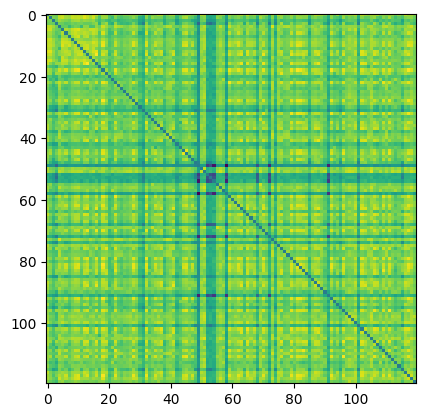

In [14]:
from matplotlib import pyplot as plt

plt.figure()
plt.imshow(scc_matrix)
plt.show()

Visualize the SCC matrix as graph:

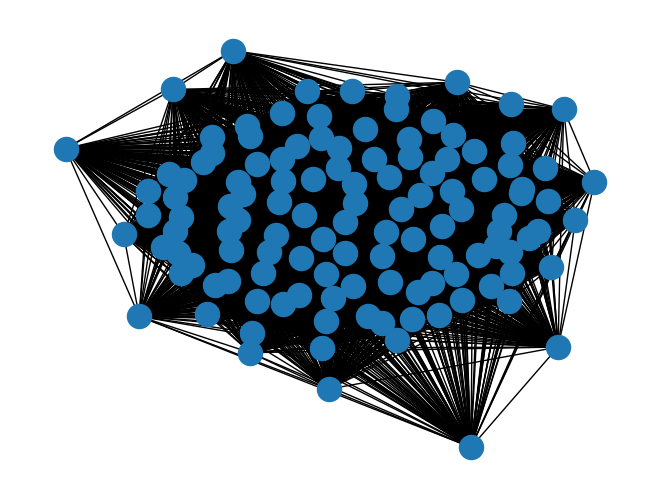

In [15]:
from matplotlib import pyplot as plt


G = nx.from_numpy_array(scc_matrix)
plt.figure()
nx.draw(G)
plt.show()

# 3. Implementing the Mapper

In this section, I apply the Mapper algorithm to the SCC matrix and visualize the Mapper complex. This part's code is taken from [GUDHI](https://gudhi.inria.fr/). 

Install the gudhi:

In [16]:
!pip install gudhi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.8 MB/s eta 0:00:00


In [17]:
from gudhi import bottleneck_distance
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
from sklearn.decomposition import PCA
from gudhi import SimplexTree, CoverComplex



import numpy as np
import itertools
import matplotlib
import matplotlib.pyplot as plt

from sklearn.base            import BaseEstimator, TransformerMixin
from sklearn.cluster         import DBSCAN, AgglomerativeClustering
from sklearn.metrics         import pairwise_distances
from scipy.spatial.distance  import directed_hausdorff

##cover_complex.py


In [18]:
class CoverComplexPy(BaseEstimator, TransformerMixin):
    """
    This is a mother class for MapperComplex, GraphInducedComplex and NerveComplex. 
    Attributes:
        simplex_tree (gudhi SimplexTree): simplicial complex representing the cover complex computed after calling the fit() method.
        node_info (dictionary): various information associated to the nodes of the cover complex. 
    """
    def __init__(self, input_name="data", cover_name="cover", color_name="color", verbose=False):
        """
        Constructor for the CoverComplexPy class.
        Parameters:
        """
        self.input_name, self.cover_name, self.color_name, self.verbose = input_name, cover_name, color_name, verbose

    def get_networkx(self, get_attrs=False):
        """
        Turn the 1-skeleton of the cover complex computed after calling fit() method into a networkx graph.
        This function requires networkx (https://networkx.org/documentation/stable/install.html).
        Parameters:
            get_attrs (bool): if True, the color functions will be used as attributes for the networkx graph.
        Returns:
            G (networkx graph): graph representing the 1-skeleton of the cover complex.
        """
        try:
            import networkx as nx
            st = self.simplex_tree
            G = nx.Graph()
            for (splx,_) in st.get_skeleton(1):	
                if len(splx) == 1:
                    G.add_node(splx[0])
                if len(splx) == 2:
                    G.add_edge(splx[0], splx[1])
            if get_attrs:
                attrs = {k: {"attr_name": self.node_info[k]["colors"]} for k in G.nodes()}
                nx.set_node_attributes(G, attrs)
            return G
        except ImportError:
            print("Networkx not found, nx graph not computed")

    def print_to_dot(self, epsv=.2, epss=.4):
        """
        Write the cover complex in a DOT file called "{self.input_name}.dot", that can be processed with, e.g., neato.
        Parameters:
            epsv (float): scale the node colors between [epsv, 1-epsv]
            epss (float): scale the node sizes between [epss, 1-epss]
        """
        st = self.simplex_tree 
        node_info = self.node_info

        maxv, minv = max([node_info[k]["colors"][0] for k in node_info.keys()]), min([node_info[k]["colors"][0] for k in node_info.keys()])
        maxs, mins = max([node_info[k]["size"]      for k in node_info.keys()]), min([node_info[k]["size"]      for k in node_info.keys()])  

        f = open(self.input_name + ".dot", "w")
        f.write("graph MAP{")
        cols = []
        for (simplex,_) in st.get_skeleton(0):
            cnode = (1.-2*epsv) * (node_info[simplex[0]]["colors"][0] - minv)/(maxv-minv) + epsv if maxv != minv else 0
            snode = (1.-2*epss) * (node_info[simplex[0]]["size"]-mins)/(maxs-mins) + epss if maxs != mins else 1
            f.write(  str(simplex[0]) + "[shape=circle width=" + str(snode) + " fontcolor=black color=black label=\""  + "\" style=filled fillcolor=\"" + str(cnode) + ", 1, 1\"]")
            cols.append(cnode)
        for (simplex,_) in st.get_filtration():
            if len(simplex) == 2:
                f.write("  " + str(simplex[0]) + " -- " + str(simplex[1]) + " [weight=15];")
        f.write("}")
        f.close()

        L = np.linspace(epsv, 1.-epsv, 100)
        colsrgb = []
        try:
            import colorsys
            for c in L:
                colsrgb.append(colorsys.hsv_to_rgb(c,1,1))
            fig, ax = plt.subplots(figsize=(6, 1))
            fig.subplots_adjust(bottom=0.5)
            my_cmap = matplotlib.colors.ListedColormap(colsrgb, name=self.color_name)
            cb = matplotlib.colorbar.ColorbarBase(ax, cmap=my_cmap, norm=matplotlib.colors.Normalize(vmin=minv, vmax=maxv), orientation="horizontal")
            cb.set_label(self.color_name)
            fig.savefig("colorbar_" + self.color_name + ".pdf", format="pdf")
            plt.close()
        except ImportError:
            print("colorsys not found, colorbar not printed")

    def print_to_txt(self):
        """
        Write the cover complex to a TXT file called "{self.input_name}.txt", that can be processed with KeplerMapper.
        """
        st = self.simplex_tree
        f = open(self.input_name + ".txt", "w")
        f.write(self.input_name + "\n")
        f.write(self.cover_name + "\n")
        f.write(self.color_name + "\n")
        f.write("0 0\n")
        f.write(str(st.num_vertices()) + " " + str(len(list(st.get_skeleton(1)))-st.num_vertices()) + "\n")
        name2id = {}
        idv = 0
        for s,_ in st.get_skeleton(0):
            f.write(str(idv) + " " + str(self.node_info[s[0]]["colors"][0]) + " " + str(self.node_info[s[0]]["size"]) + "\n")
            name2id[s[0]] = idv
            idv += 1
        for s,_ in st.get_skeleton(1):
            if len(s) == 2:
                f.write(str(name2id[s[0]]) + " " + str(name2id[s[1]]) + "\n")
        f.close()

    class _constant_clustering():
        def fit_predict(X):
            return np.zeros([len(X)], dtype=np.int32)


class MapperComplex(CoverComplexPy, BaseEstimator, TransformerMixin):
    """
    This is a class for computing Mapper simplicial complexes on point clouds or distance matrices.
    """
    def __init__(self, input_type="point cloud", colors=None, mask=0,
                       filters=None, filter_bnds=None, resolutions=None, gains=None, clustering=DBSCAN(), N=100, beta=0., C=10.,
                       input_name="data", cover_name="cover", color_name="color", verbose=False):
        """
        Constructor for the MapperComplex class.
        Parameters:
            input_type (string): type of input data. Either "point cloud" or "distance matrix".
            colors (numpy array of shape (num_points) x (num_colors)): functions used to color the nodes of the cover complex. More specifically, coloring is done by computing the means of these functions on the subpopulations corresponding to each node. If None, first coordinate is used if input is point cloud, and eccentricity is used if input is distance matrix.
            mask (int): threshold on the size of the cover complex nodes (default 0). Any node associated to a subpopulation with less than **mask** points will be removed.
            filters (numpy array of shape (num_points) x (num_filters)): filter functions (sometimes called lenses) used to compute the cover. Each column of the numpy array defines a scalar function defined on the input points.
            filter_bnds (numpy array of shape (num_filters) x 2): limits of each filter, of the form [[f_1^min, f_1^max], ..., [f_n^min, f_n^max]]. If one of the values is numpy.nan, it can be computed from the dataset with the fit() method.
            resolutions (numpy array of shape num_filters containing integers): resolution of each filter function, ie number of intervals required to cover each filter image. If None, it is estimated from data.
            gains (numpy array of shape num_filters containing doubles in [0,1]): gain of each filter function, ie overlap percentage of the intervals covering each filter image.
            clustering (class): clustering class (default sklearn.cluster.DBSCAN()). Common clustering classes can be found in the scikit-learn library (such as AgglomerativeClustering for instance). If None, it is set to hierarchical clustering, with scale estimated from data.
            N (int): subsampling iterations (default 100) for estimating scale and resolutions. Used only if clustering or resolutions = None. See http://www.jmlr.org/papers/volume19/17-291/17-291.pdf for details.
            beta (double): exponent parameter (default 0.) for estimating scale and resolutions. Used only if clustering or resolutions = None. See http://www.jmlr.org/papers/volume19/17-291/17-291.pdf for details.
            C (double): constant parameter (default 10.) for estimating scale and resolutions. Used only if clustering or resolutions = None. See http://www.jmlr.org/papers/volume19/17-291/17-291.pdf for details.
            input_name (string): name of dataset. Used when generating plots.
            cover_name (string): name of cover. Used when generating plots.
            color_name (string): name of color function. Used when generating plots.
            verbose (bool): whether to display info while computing.
        """
        self.filters, self.filter_bnds, self.resolutions, self.gains, self.colors, self.clustering = filters, filter_bnds, resolutions, gains, colors, clustering
        self.input_type, self.mask, self.N, self.beta, self.C = input_type, mask, N, beta, C
        CoverComplexPy.__init__(self, input_name, cover_name, color_name, verbose)

    def estimate_scale(self, X, N=100, inp="point cloud", beta=0., C=10.):
        """
        Compute estimated scale of a point cloud or a distance matrix.
        Parameters:
            X (numpy array of shape (num_points) x (num_coordinates) if point cloud and (num_points) x (num_points) if distance matrix): input point cloud or distance matrix.
            N (int): subsampling iterations (default 100). See http://www.jmlr.org/papers/volume19/17-291/17-291.pdf for details.
            inp (string): either "point cloud" or "distance matrix". Type of input data (default "point cloud").
            beta (double): exponent parameter (default 0.). See http://www.jmlr.org/papers/volume19/17-291/17-291.pdf for details.
            C (double): constant parameter (default 10.). See http://www.jmlr.org/papers/volume19/17-291/17-291.pdf for details.
        Returns:
            delta (double): estimated scale that can be used with eg agglomerative clustering.
        """
        num_pts = X.shape[0]
        delta, m = 0., int(  num_pts / np.exp((1+beta) * np.log(np.log(num_pts)/np.log(C)))  )
        for _ in range(N):
            subpop = np.random.choice(num_pts, size=m, replace=False)
            if inp == "point cloud":
                d, _, _ = directed_hausdorff(X, X[subpop,:])
            if inp == "distance matrix":
                d = np.max(np.min(X[:,subpop], axis=1), axis=0)
            delta += d/N
        return delta

    def get_optimal_parameters_for_agglomerative_clustering(self, X, beta=0., C=10., N=100):
        """
        Compute optimal scale and resolutions for a point cloud or a distance matrix.
        Parameters:
            X (numpy array of shape (num_points) x (num_coordinates) if point cloud and (num_points) x (num_points) if distance matrix): input point cloud or distance matrix.
            beta (double): exponent parameter (default 0.). See http://www.jmlr.org/papers/volume19/17-291/17-291.pdf for details.
            C (double): constant parameter (default 10.). See http://www.jmlr.org/papers/volume19/17-291/17-291.pdf for details.
            N (int): subsampling iterations (default 100). See http://www.jmlr.org/papers/volume19/17-291/17-291.pdf for details.
        Returns:
            delta (double): optimal scale that can be used with agglomerative clustering.
            resolutions (numpy array of shape (num_filters): optimal resolutions associated to each filter.
        """
        num_filt, delta = self.filters.shape[1], 0
        delta = self.estimate_scale(X=X, N=N, inp=self.input_type, C=C, beta=beta)

        pairwise = pairwise_distances(X, metric="euclidean") if self.input_type == "point cloud" else X
        pairs = np.argwhere(pairwise <= delta)
        num_pairs = pairs.shape[0]
        res = []
        for f in range(num_filt):
            F = self.filters[:,f]
            resf = 0
            for p in range(num_pairs):
                resf = max(resf, abs(F[pairs[p,0]] - F[pairs[p,1]]))
            res.append(resf)

        return delta, np.array(res)

    def fit(self, X, y=None):
        """
        Fit the MapperComplex class on a point cloud or a distance matrix: compute the Mapper complex and store it in a simplex tree called simplex_tree.
        Parameters:
            X (numpy array of shape (num_points) x (num_coordinates) if point cloud and (num_points) x (num_points) if distance matrix): input point cloud or distance matrix.
            y (n x 1 array): point labels (unused).
        """
        if self.filters is None:
            if self.input_type == "point cloud":
                self.filters = X[:,0:1]
            elif self.input_type == "distance matrix":
                self.filters = X.max(axis=0)[:,None]
        if self.colors is None:
            if self.input_type == "point cloud":
                self.colors = X[:,0:1]
            elif self.input_type == "distance matrix":
                self.colors = X.max(axis=0)[:,None]

        num_pts, num_filters = self.filters.shape[0], self.filters.shape[1]

        # If some filter limits are unspecified, automatically compute them
        if self.filter_bnds is None: 
            self.filter_bnds = np.hstack([np.min(self.filters, axis=0)[:,np.newaxis], np.max(self.filters, axis=0)[:,np.newaxis]])

        # If some resolutions are not specified, automatically compute them
        if self.gains is None:
            self.gains = .33 * np.ones(num_filters)
        if self.resolutions is None or self.clustering is None:
            delta, resolutions = self.get_optimal_parameters_for_agglomerative_clustering(X=X, beta=self.beta, C=self.C, N=self.N)
            if self.clustering is None:
                if self.input_type == "point cloud":
                    self.clustering = AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=delta, affinity="euclidean")  
                else:
                    self.clustering = AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=delta, affinity="precomputed")
            if self.resolutions is None:
                self.resolutions = np.multiply(resolutions, 1./self.gains)
                self.resolutions = np.array([int( (self.filter_bnds[ir,1]-self.filter_bnds[ir,0])/r) for ir, r in enumerate(self.resolutions)])

        # Initialize attributes
        self.simplex_tree, self.node_info = SimplexTree(), {}

        if np.all(self.gains < .5):
            
            # Compute which points fall in which patch or patch intersections
            interval_inds, intersec_inds = np.empty(self.filters.shape), np.empty(self.filters.shape)
            for i in range(num_filters):
                f, r, g = self.filters[:,i], self.resolutions[i], self.gains[i]
                min_f, max_f = self.filter_bnds[i,0], np.nextafter(self.filter_bnds[i,1], np.inf)
                interval_endpoints, l = np.linspace(min_f, max_f, num=r+1, retstep=True)
                intersec_endpoints = []
                for j in range(1, len(interval_endpoints)-1):
                    intersec_endpoints.append(interval_endpoints[j] - g*l / (2 - 2*g))
                    intersec_endpoints.append(interval_endpoints[j] + g*l / (2 - 2*g))
                interval_inds[:,i] = np.digitize(f, interval_endpoints)
                intersec_inds[:,i] = 0.5 * (np.digitize(f, intersec_endpoints) + 1)

            # Build the binned_data map that takes a patch or a patch intersection and outputs the indices of the points contained in it
            binned_data = {}
            for i in range(num_pts):
                list_preimage = []
                for j in range(num_filters):
                    a, b = interval_inds[i,j], intersec_inds[i,j]
                    list_preimage.append([a])
                    if b == a:
                        list_preimage[j].append(a+1)
                    if b == a-1:
                        list_preimage[j].append(a-1)
                list_preimage = list(itertools.product(*list_preimage))
                for pre_idx in list_preimage:
                    try:
                        binned_data[pre_idx].append(i)
                    except KeyError:
                        binned_data[pre_idx] = [i]

        else:

            # Compute interval endpoints for each filter
            l_int, r_int = [], []
            for i in range(num_filters):
                L, R = [], []
                f, r, g = self.filters[:,i], self.resolutions[i], self.gains[i]
                min_f, max_f = self.filter_bnds[i,0], np.nextafter(self.filter_bnds[i,1], np.inf)
                interval_endpoints, l = np.linspace(min_f, max_f, num=r+1, retstep=True)
                for j in range(len(interval_endpoints)-1):
                    L.append(interval_endpoints[j]   - g*l / (2 - 2*g))
                    R.append(interval_endpoints[j+1] + g*l / (2 - 2*g))
                l_int.append(L)
                r_int.append(R)

            # Build the binned_data map that takes a patch or a patch intersection and outputs the indices of the points contained in it
            binned_data = {}
            for i in range(num_pts):
                list_preimage = []
                for j in range(num_filters):
                    fval = self.filters[i,j]
                    start, end = int(min(np.argwhere(np.array(r_int[j]) >= fval))), int(max(np.argwhere(np.array(l_int[j]) <= fval)))
                    list_preimage.append(list(range(start, end+1)))
                list_preimage = list(itertools.product(*list_preimage))
                for pre_idx in list_preimage:
                    try:
                        binned_data[pre_idx].append(i)
                    except KeyError:
                        binned_data[pre_idx] = [i]

        # Initialize the cover map, that takes a point and outputs the clusters to which it belongs
        cover, clus_base = [[] for _ in range(num_pts)], 0

        # For each patch
        for preimage in binned_data:

            # Apply clustering on the corresponding subpopulation
            idxs = np.array(binned_data[preimage])
            if len(idxs) > 1:
                clusters = self.clustering.fit_predict(X[idxs,:]) if self.input_type == "point cloud" else self.clustering.fit_predict(X[idxs,:][:,idxs])
            elif len(idxs) == 1:
                clusters = np.array([0])
            else:
                continue

            # Collect various information on each cluster
            num_clus_pre = np.max(clusters) + 1
            for clus_i in range(num_clus_pre):
                node_name = clus_base + clus_i
                subpopulation = idxs[clusters == clus_i]
                self.node_info[node_name] = {}
                self.node_info[node_name]["indices"] = subpopulation
                self.node_info[node_name]["size"] = len(subpopulation)
                self.node_info[node_name]["colors"] = np.mean(self.colors[subpopulation,:], axis=0)
                self.node_info[node_name]["patch"] = preimage

            # Update the cover map
            for pt in range(clusters.shape[0]):
                node_name = clus_base + clusters[pt]
                if clusters[pt] != -1 and self.node_info[node_name]["size"] >= self.mask:
                    cover[idxs[pt]].append(node_name)

            clus_base += np.max(clusters) + 1

        # Insert the simplices of the Mapper complex 
        for i in range(num_pts):
            self.simplex_tree.insert(cover[i])

        return self


##Helper functions

In [19]:
from scipy.sparse.csgraph    import dijkstra, shortest_path, connected_components
from scipy.stats             import ks_2samp, entropy, ttest_ind

def find(i, parents):
    if parents[i] == i:
        return i
    else:
        return find(parents[i], parents)

def union(i, j, parents, f):
    if f[i] <= f[j]:
        parents[j] = i
    else:
        parents[i] = j
        
def compute_topological_features(M, threshold=0.):
    """
    Compute the topological features (connected components, up/down branches, loops) of 
    the 1-skeleton of the cover complex. Connected components and loops are computed with scipy 
    functions, and branches are detected with Union-Find and 0-dimensional persistence of the 1-skeleton.
    Parameters:
        threshold (float): any topological feature whose size is less than this parameter 
        (relative to the first color function) will be discarded.
    Returns:
        dgm (list of (dim,(a,b)) tuples): list of feature characteristics. dim is the 
        topological dimension of the feature (0 for CCs and branches, 1 for loops), a,b are the min and max 
        of the first color function along the feature.
        bnds (list of lists): list of feature points. Each element of this list is the list of point IDs 
        forming the corresponding feature. 
    """
    st = M.simplex_tree
    num_nodes = st.num_vertices()
    function, namefunc, invnamefunc = {}, {}, {}
    nodeID = 0
    for (s,_) in st.get_skeleton(0):
        namefunc[s[0]] = nodeID
        invnamefunc[nodeID] = s[0]
        function[s[0]] = M.node_info[s[0]]["colors"][0]
        nodeID += 1
    dgm, bnd = [], []

    # connected_components
    A = np.zeros([num_nodes, num_nodes])
    for (splx,_) in st.get_skeleton(1):
        if len(splx) == 2:
            A[namefunc[splx[0]], namefunc[splx[1]]] = 1
            A[namefunc[splx[1]], namefunc[splx[0]]] = 1
    _, ccs = connected_components(A, directed=False)
    for ccID in np.unique(ccs):
        pts = np.argwhere(ccs == ccID).flatten()
        vals = [function[invnamefunc[p]] for p in pts]
        if np.abs(min(vals) - max(vals)) >= threshold:
            dgm.append((0, (min(vals), max(vals))))
            bnd.append([invnamefunc[p] for p in pts])

    # loops
    G = M.get_networkx()
    try:
        from networkx import cycle_basis
        bndall = cycle_basis(G)
        for pts in bndall:
            vals = [function[p] for p in pts]
            if np.abs(min(vals) - max(vals)) >= threshold:	
                dgm.append((1,(min(vals), max(vals))))
                bnd.append(pts)
    except ImportError:
        print("Networkx not found, loops not computed")
        
    # branches
    for topo_type in ["downbranch", "upbranch"]:

        lfunction = []
        for i in range(num_nodes):
            lfunction.append(function[invnamefunc[i]])

        # upranch is downbranch of opposite function
        if topo_type == "upbranch":
            lfunction = [-f for f in lfunction]

        # sort vertices according to function values and compute inverse function 
        sorted_idxs = np.argsort(np.array(lfunction))
        inv_sorted_idxs = np.zeros(num_nodes)
        for i in range(num_nodes):
            inv_sorted_idxs[sorted_idxs[i]] = i

        # go through all vertices in ascending function order
        persistence_diag, persistence_set, parents, visited = {}, {}, -np.ones(num_nodes, dtype=np.int32), {}
        for i in range(num_nodes):

            current_pt = sorted_idxs[i]
            neighbors = np.ravel(np.argwhere(A[current_pt,:] == 1))
            lower_neighbors = [n for n in neighbors if inv_sorted_idxs[n] <= i] if len(neighbors) > 0 else []

            # no lower neighbors: current point is a local minimum
            if lower_neighbors == []:
                parents[current_pt] = current_pt

            # some lower neighbors exist
            else:

                # find parent pg of lower neighbors with lowest function value
                neigh_parents = [find(n, parents) for n in lower_neighbors]
                pg = neigh_parents[np.argmin([lfunction[n] for n in neigh_parents])]

                # set parent of current point to pg
                parents[current_pt] = pg

                # for each lower neighbor, we will create a persistence diagram point and corresponding set of nodes
                for neighbor in lower_neighbors:

                    # get parent pn
                    pn = find(neighbor, parents)
                    val = lfunction[pn]
                    persistence_set[pn] = []

                    # we will create persistence set only if parent pn is not local minimum pg
                    if pn != pg:
                        # go through all strictly lower nodes with parent pn
                        for v in sorted_idxs[:i]:
                            if find(v, parents) == pn:
                                # if it is already part of another persistence set, continue
                                try:
                                    visited[v]
                                # else, mark visited and include it in current persistence set
                                except KeyError:
                                    visited[v] = True
                                    persistence_set[pn].append(v)

                        # add current point to persistence set
                        persistence_set[pn].append(current_pt)

                        # do union and create persistence point corresponding to persistence set if persistence is sufficiently large
                        if np.abs(lfunction[pn]-lfunction[current_pt]) >= threshold:
                            persistence_diag[pn] = current_pt
                            union(pg, pn, parents, lfunction)

        for key, val in iter(persistence_diag.items()):
            if topo_type == "downbranch":
                dgm.append((0, (lfunction[key],  lfunction[val])))
            elif topo_type == "upbranch":
                dgm.append((0, (-lfunction[val], -lfunction[key])))
            bnd.append([invnamefunc[v] for v in persistence_set[key]])

    bnd = [list(b) for b in bnd]
    M.persistence_diagram, M.persistence_sets = dgm, bnd 
    return dgm, bnd

def bootstrap_topological_features(M, N):
    """
    Use bootstrap to empirically assess stability of the features. This function computes a distribution of 
    bottleneck distances, that can used afterwards to run tests on each topological feature.
    Parameters:
        N (int): number of bootstrap iterations.
    """

    dgm = M.persistence_diagram
    num_pts, distribution = len(M.data), []
    for bootstrap_id in range(N):

        print(str(bootstrap_id) + "th iteration")

        # Randomly select points
        idxs = np.random.choice(num_pts, size=num_pts, replace=True)
        Xboot = M.data[idxs,:] if M.input_type == "point cloud" else M.data[idxs,:][:,idxs]
        f_boot, c_boot = M.filters[idxs,:], M.colors[idxs,:]
        Mboot = M.__class__(filters=f_boot, filter_bnds=M.filter_bnds, colors=c_boot, 
                            resolutions=M.resolutions, gains=M.gains, 
                            input_type=M.input_type, clustering=M.clustering).fit(Xboot)

        # Compute the corresponding persistence diagrams
        dgm_boot, _ = compute_topological_features(Mboot)

        # Compute the bottleneck distance
        npts, npts_boot = len(dgm), len(dgm_boot)
        D1 = np.array([[dgm[pt][1][0], dgm[pt][1][1]] for pt in range(npts)]) 
        D2 = np.array([[dgm_boot[pt][1][0], dgm_boot[pt][1][1]] for pt in range(npts_boot)])
        bottle = bottleneck_distance(D1, D2)
        distribution.append(bottle)
        M.distribution = np.sort(distribution)

def get_distance_from_confidence_level(M, alpha=.95, complex_type='mapper'):
    """
    Compute the bottleneck distance threshold corresponding to a specific confidence level.
    Parameters:
        alpha (float): confidence level.
    Returns:
        distance value (float); each feature whose size is above this distance is sure at confidence level alpha.
    """
    return M.distribution[int(alpha*len(M.distribution))]

def get_confidence_level_from_distance(M, distance):
    """
    Compute the confidence level of a specific bottleneck distance threshold.
    Parameters:
        distance (float): bottleneck distance threshold.
    Returns:
        confidence level (float); each feature whose size is above the distance threshold is sure at 
        this confidence level.
    """
    return len(np.argwhere(M.distribution <= distance))/len(M.distribution)

def get_pvalue(M):
    """
    Compute the p-value, i.e. the opposite of the confidence level of the largest bottleneck distance 
    preserving the topological features.
    Returns:
        p-value (float)
    """
    distancemin = min([np.abs(pt[1][0]-pt[1][1]) for pt in M.persistence_diagram])
    return 1.-M.compute_confidence_from_distance(distancemin)

def compute_differential_coordinates(M, nodes=None, features=None, sparse=False):
    """
    Compute the coordinates that best explain a set of nodes VS the rest of the nodes 
    (in the 1-skeleton of the cover complex) with a Kolmogorov-Smirnov test. 
    Only works if input_type is "point cloud".
    Parameters:
        nodes (list of integers): list of nodes to try. For instance, one can take the list of 
        nodes obtained after calling "compute_topological_features"
        features (list of integers): the coordinates to try. All coordinates are tested if None.
        sparse (bool): set to True if your data is sparse and there will be speedup, otherwise use False.
    Returns:
        features (list of integers): the list of coordinates, ranked from smallest to largest p-values.
        p-values (list of float): the corresponding p-values. 
    """
    if M.input_type == "distance matrix":
        print("Need coordinates for running differential coordinates!")
        raise
    #coordinates_and_pvalues = compute_differential_coordinates(cover_complex, nodes=bnd_temp[i])

    node_info = M.node_info
    X = M.data
    nodes = [s[0] for s,_ in self.simplex_tree.get_skeleton(0)] if nodes is None else nodes

    if features is None:
        features = np.arange(X.shape[1])

    #The data points create this communities
    list_idxs1 = list(np.unique(np.concatenate([node_info[node_name]["indices"] for node_name in nodes])))

    #Other data points that do not create this community
    list_idxs2 = list(set(np.arange(X.shape[0]))-set(list_idxs1))

    pvals = []
    ttvals = []
    tpvals = []
    for f in features:
        if sparse:
            Xsp = csr_matrix(X)
            group1 = np.squeeze(np.array(Xsp[list_idxs1,f].todense()))
            group2 = np.squeeze(np.array(Xsp[list_idxs2,f].todense()))
        else:
            group1, group2 = X[list_idxs1,f], X[list_idxs2,f]
        
        _,pval = ks_2samp(group1, group2)
        
        #ttval = ttest_ind(group1, group2)[0]
        #tpval = ttest_ind(group1, group2)[1]

        pvals.append(pval)
        
        #tpvals.append(tpval)
        #ttvals.append(ttval)
    
    pvals = np.array(pvals)
    
    #tpvals= np.array(tpvals)
    #ttvals= np.array(ttvals)

    F_ks, P_ks = features[np.argsort(pvals)], np.sort(pvals)
    #F_ent, P_ent = features[np.argsort(entvals)], np.sort(entvals) 
    return F_ks, P_ks #, np.argsort(ttvals), np.sort(ttvals)

##3.1 Complex computation

Mapper is a computational method for complex datasets to extract the simplest information in the form of simplicial complexes that conserve the underlying topological structures from the original data. It is used for the visualization of high-dimensional datasets, simplification, and qualitative analysis. The idea is to partially cluster the data that is guided by scalar filter functions. The resulting visualization is a simple collapse of data into a low-dimensional graph, where the filter function acts as guidance.

I will first implement the Mapper algorithm and then test its parameters.  As a filter, the eigenfunctions of a Kernel PCA are used. There are also two other parameters in the Mapper called resolution and gain. Resolution refers to the number of intervals required to cover each filtered image; the output is a natural number. If one increases the resolution, then the number of communities obtained through the Mapper result increases as well. 

The gain parameter is the overlap percentage of the intervals covering each filtered image. The range of the gain parameter is $[0,1]$; it is a real number. If one increases the gain, then the connection between communities increases too, and, as a result, the number of edges between nodes in the Mapper result increases. Users should decide about these two parameters carefully in order to obtain an efficient topological representation of their data. 

####Implement the PCA filter:

I use the [sklearn PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for filter calculation. Firstly, I used the first component of the PCA, then tried to use the second component in the parameter search section.

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
PCA_filter = pca.fit_transform(scc_matrix)

print(PCA_filter.shape)

(120, 1)


####Define the Mapper:

Since the input is a similarity matrix, the color is given by eccentricity.

In [25]:
ecc = scc_matrix.max(axis=0)

The cover complex can now be computed in a single line of code!

In [26]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering



res = np.array([50])
gain = np.array([0.8])

cover_complex = MapperComplex(
    input_type='distance matrix', colors=ecc[:,np.newaxis], mask=0,
    
    #Select the clustering algorithm:
    clustering=DBSCAN(eps = 0.5, min_samples=5, metric ="cosine"),
    #clustering=AgglomerativeClustering(n_clusters=None, linkage="complete", distance_threshold=0.5, affinity="cosine"),
    
    N=100, beta=0., C=10,
    filters=PCA_filter , 
    filter_bnds=None, 
    
    #resolutions=np.array([13, 13]),
    #gains=np.array([0.3, 0.1]),

    #Resolutions = Number of intervals required to cover each filter image. When you increase this, num of communities increase
    resolutions = res, 
    #Gains = Overlap percentage of the intervals covering each filter image. When you decrease this, data-points lose connections 
    gains = gain,  

    input_name="human", cover_name="coord2", color_name="coord2", verbose=True)

In [27]:
from gudhi import SimplexTree, CoverComplex

_ = cover_complex.fit(scc_matrix)

### Visualization

Visualize the Mapper result:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

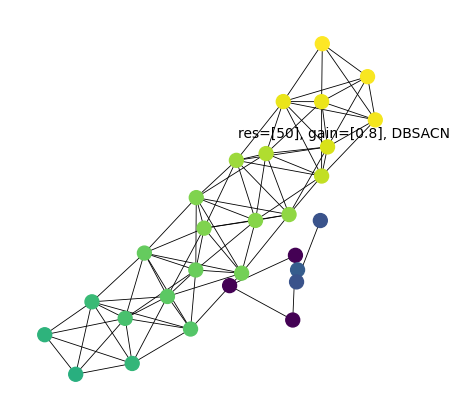

<Figure size 640x480 with 0 Axes>

In [28]:
%matplotlib notebook
%matplotlib inline
import networkx as nx

G = cover_complex.get_networkx()

plt.figure(figsize=(4,4))
nx.draw(G, pos=nx.kamada_kawai_layout(G), node_color=[cover_complex.node_info[v]["colors"][0] for v in G.nodes()], node_size=100, width=0.6)

parameters = "res="+str(res)+', '+'gain='+str(gain)+', '+'DBSACN'
plt.text(0, 0.5, parameters, fontsize = 10)


plt.show()
plt.savefig("deneme.png")

Till now we implemented the Mapper for SCC similarity matrix without a problem! The result of the Mapper is depend on the resolution, gain, clustering algorithm, and filter function. We need to find a set of parameters for which the cell cycle can be detected as a big loop in the Mapper. In the next section, we will search for parameters.

#4. Parameter Search


Before starting, I will define a function that returns the Mapper complex of a given distance matrix:

In [95]:
def give_me_mapper(scc_matrix, resolution, gain, filter,  clustering, color=None, color_vector = None ):

  #Coloring: If color_vector is not specified, we use the ecc.
  if color == 'ecc':
    colors = scc_matrix.max(axis=0)
  else:
    colors = color_vector

  #Select the clustering algorithm
  if clustering == 'DBSCAN':
    clustering = DBSCAN(eps = 0.5, min_samples=5, metric ="cosine")
  elif clustering == 'Agg':
    clustering = AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=0.5, affinity="jaccard")
    #clustering = AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=0.5, affinity="cosine")


  #Define the Mapper complex:
  cover_complex = MapperComplex(
    input_type='distance matrix', 
    colors=colors[:,np.newaxis], mask=0,
    clustering= clustering,
    
    N=100, beta=0., C=10,
    filters=filter , 
    filter_bnds=None, 
    
    resolutions= np.array([resolution]),
    gains= np.array([gain/100.0]),

    input_name="human", cover_name="coord2", color_name="coord2", verbose=True)
  return cover_complex



###3.2.1 PCA 1st comp. as Filter

We will test the gain and resolution parameters as well as clustering algorithms using only the first component of PCA. We will use only one filter here whose shape is (120, 1). 

####Agglomerative Clustering / PCA(n_components=1)

In Agglomerative Clustering I tried two distance measures(i.e the "affinity" parameter) such as cosine similarity and jaccard distance. The Jaccar distance could give a Mapper complex with a loop that is found after the parameter search.

Loop over different parameters and plot the Mapper result and see if there is a loop:

(120, 1)
res= 30  gain= 0.55


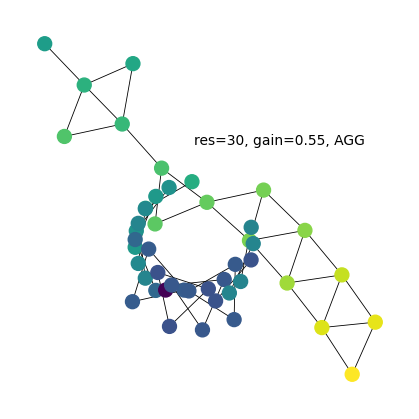

res= 30  gain= 0.58


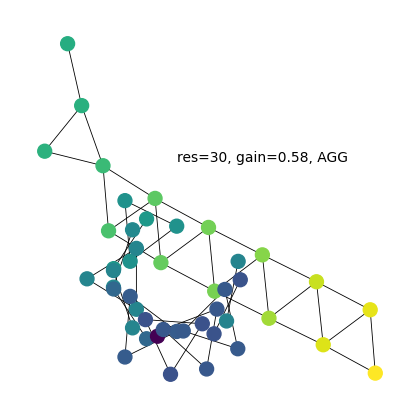

res= 30  gain= 0.61


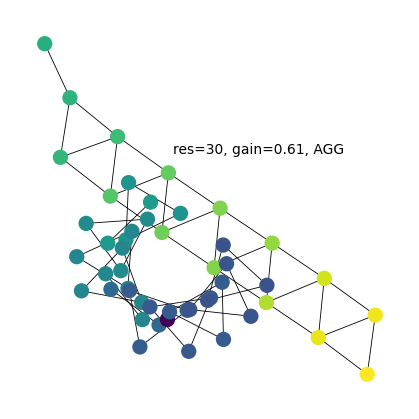

res= 30  gain= 0.64


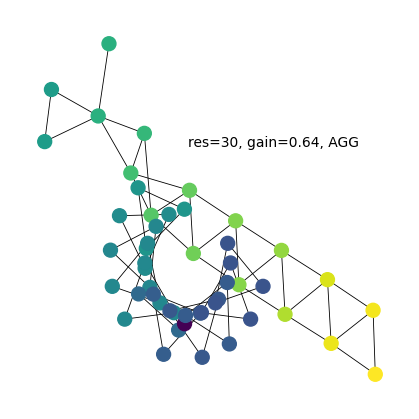

res= 30  gain= 0.67


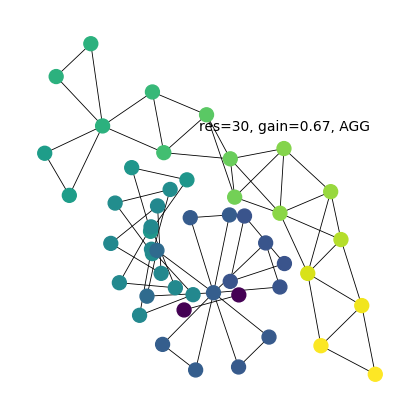

res= 30  gain= 0.7


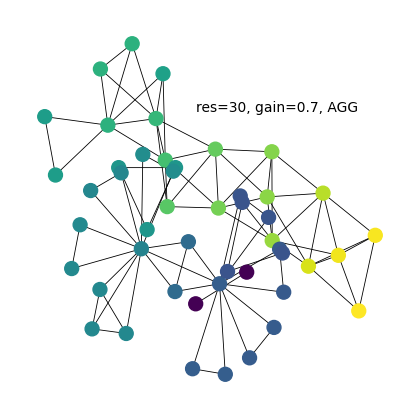

res= 30  gain= 0.73


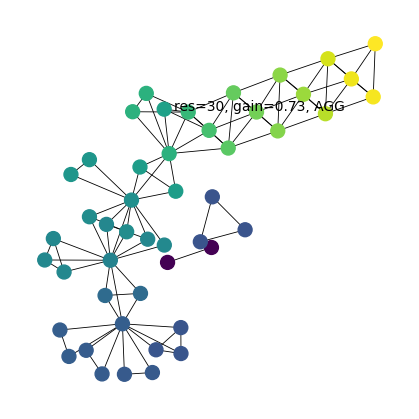

res= 33  gain= 0.55


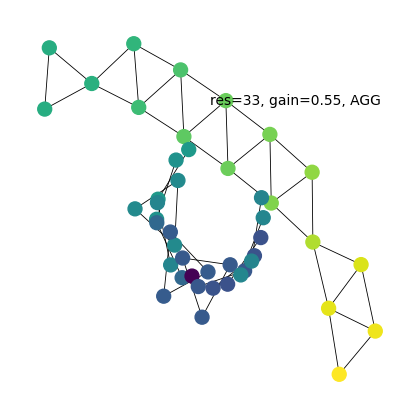

res= 33  gain= 0.58


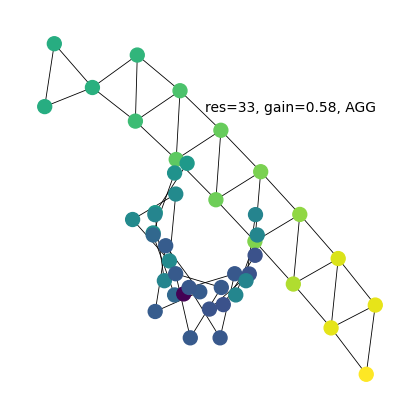

res= 33  gain= 0.61


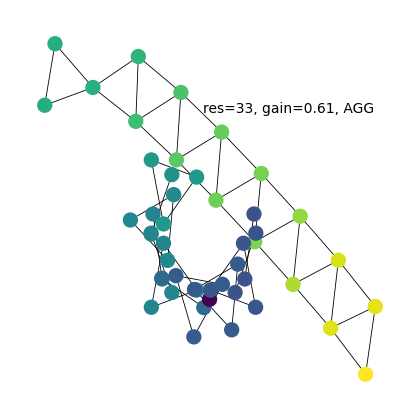

res= 33  gain= 0.64


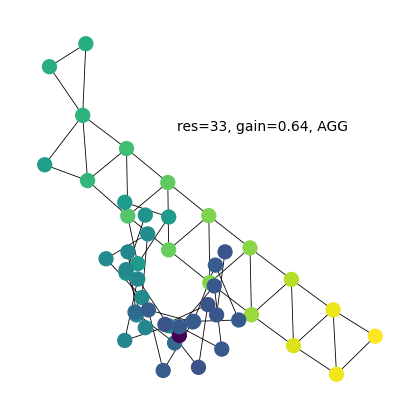

res= 33  gain= 0.67


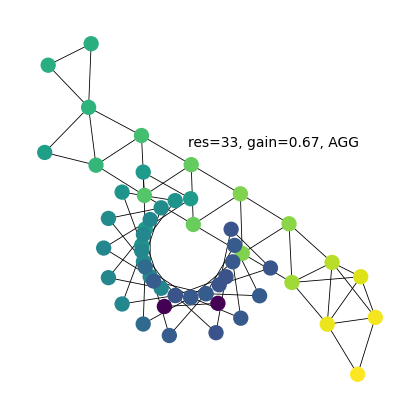

res= 33  gain= 0.7


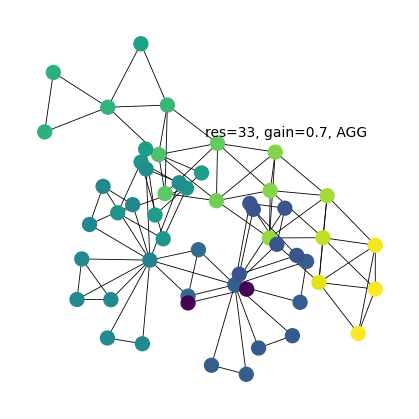

res= 33  gain= 0.73


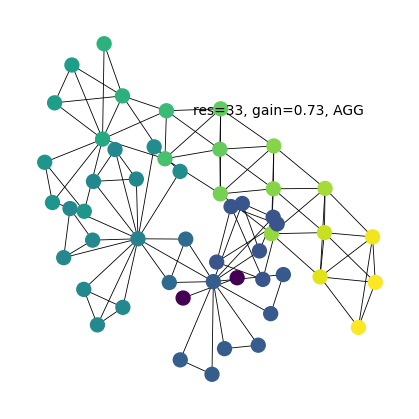

res= 36  gain= 0.55


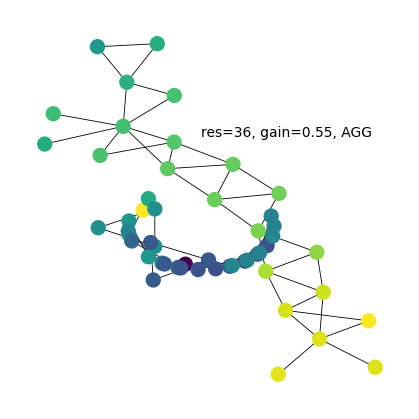

res= 36  gain= 0.58


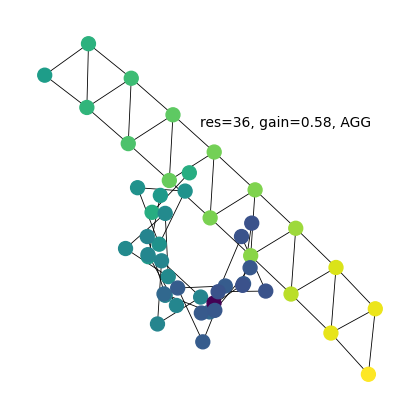

res= 36  gain= 0.61


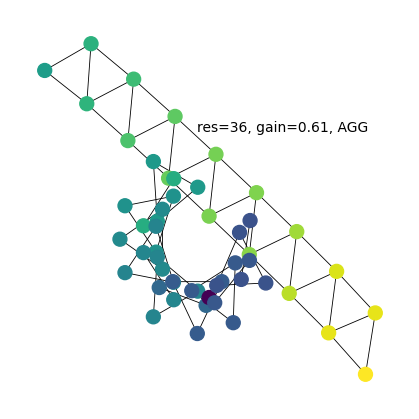

res= 36  gain= 0.64


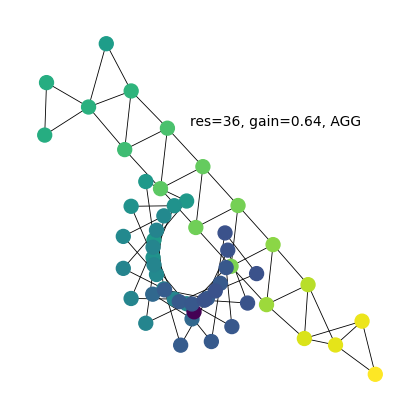

res= 36  gain= 0.67


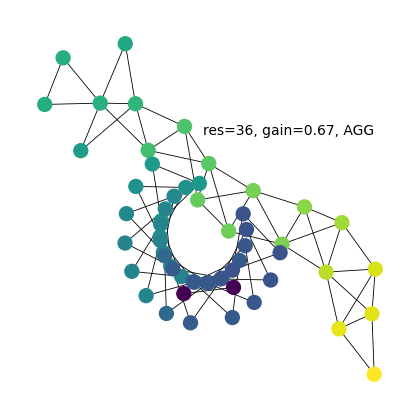

res= 36  gain= 0.7


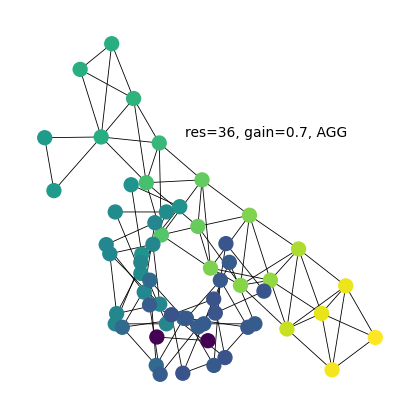

res= 36  gain= 0.73


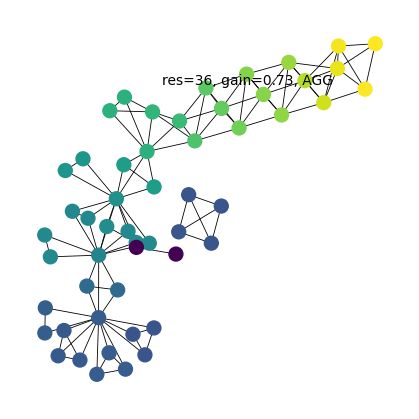

res= 39  gain= 0.55


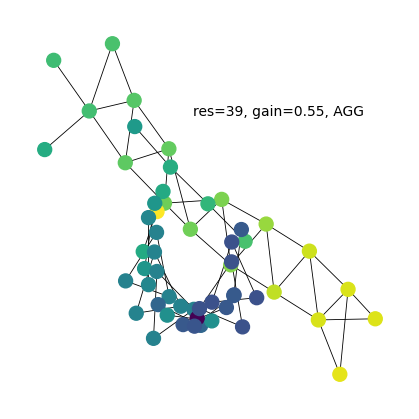

res= 39  gain= 0.58


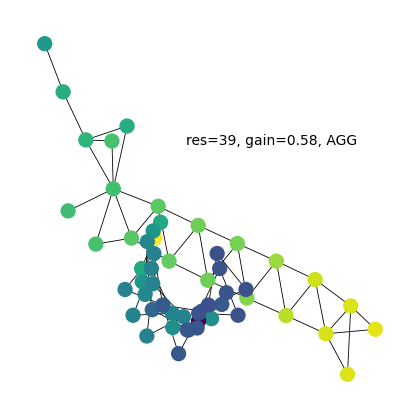

res= 39  gain= 0.61


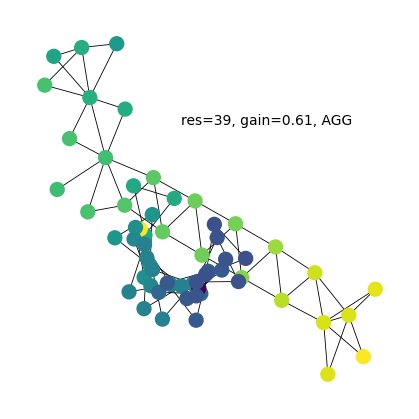

res= 39  gain= 0.64


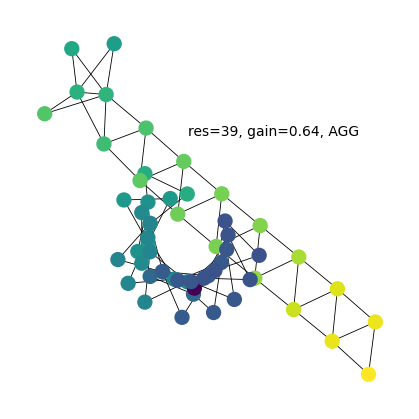

res= 39  gain= 0.67


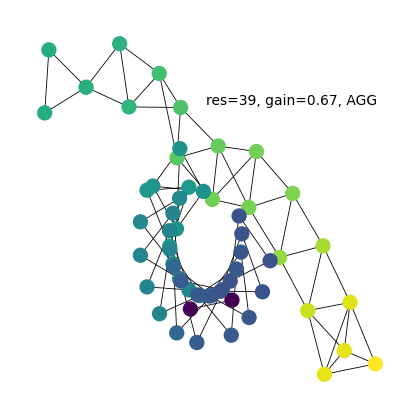

res= 39  gain= 0.7


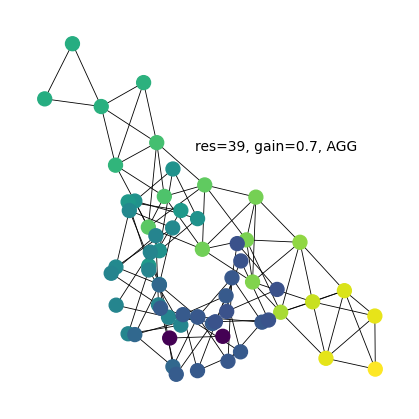

res= 39  gain= 0.73


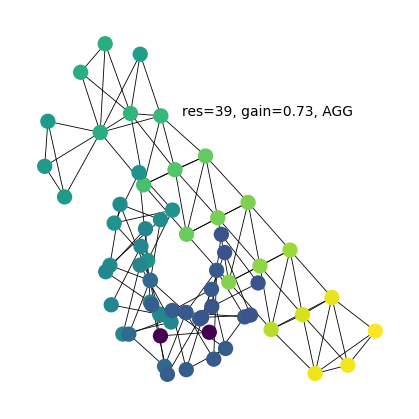

In [56]:
import warnings
warnings.filterwarnings('ignore')

#Define the filter again:
from sklearn.decomposition import PCA

#PCA 1st component only
pca = PCA(n_components=1)
PCA_filter = pca.fit_transform(scc_matrix)
print(PCA_filter.shape)


#Loop over different parameters:
for resolution in range(30,40,3):
  for gain in range(55,75,3):
    print("res=",resolution," gain=",gain/100)

    cover_complex = give_me_mapper(scc_matrix, resolution, gain, PCA_filter,  clustering='Agg', color='ecc' )
    #Run the cover complex
    _ = cover_complex.fit(scc_matrix)

    #Save the plot 
    G = cover_complex.get_networkx()
    plt.figure(figsize=(4,4))
    nx.draw(G, pos=nx.kamada_kawai_layout(G), node_color=[cover_complex.node_info[v]["colors"][0] for v in G.nodes()], node_size=100, width=0.6)
    parameters = "res="+str(resolution)+', '+'gain='+str(gain/100)+', '+'AGG'
    plt.text(0, 0.5, parameters, fontsize = 10)
    plt.show()


We found one Mapper complex that has a loop inside. The parameters of this complex are:

*   resolution = 33, 
*   gain = 73, 
*   filter = PCA first component,  
*   clustering = Agglomerative Clustering

This is a good result. Let's visalize it.

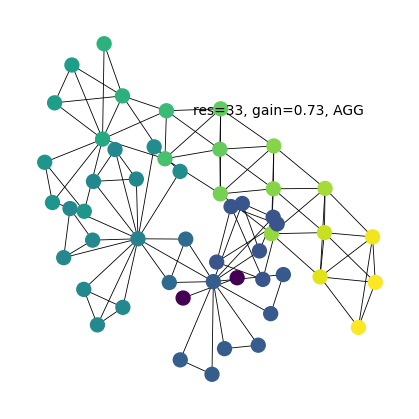

In [88]:
#Define the filter (again)
pca = PCA(n_components=1)
PCA_filter = pca.fit_transform(scc_matrix)

cover_complex = give_me_mapper(scc_matrix, 33, 73, PCA_filter,  clustering='Agg', color='ecc' )
#Run the cover complex
_ = cover_complex.fit(scc_matrix)

#Save the plot 
G = cover_complex.get_networkx()
plt.figure(figsize=(4,4))
nx.draw(G, pos=nx.kamada_kawai_layout(G), node_color=[cover_complex.node_info[v]["colors"][0] for v in G.nodes()], node_size=100, width=0.6)
parameters = "res="+str(33)+', '+'gain='+str(73/100)+', '+'AGG'
plt.text(0, 0.5, parameters, fontsize = 10)
plt.show()

This Mapper complex can be our selection because there seems a little loop in the middle. We will search other parameters in the following cells.

####DBSCAN / PCA(n_components=1)

(120, 1)
res= 45  gain= 0.85


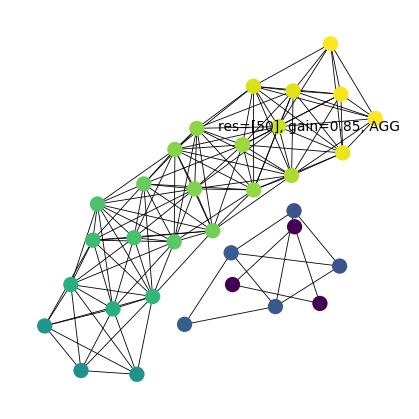

res= 45  gain= 0.88


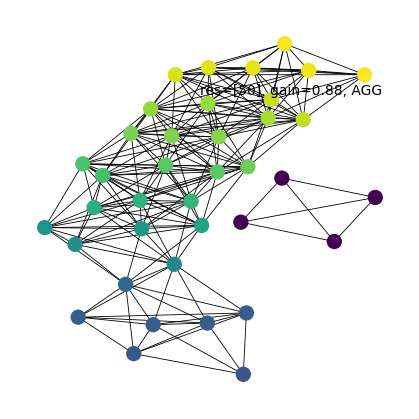

res= 45  gain= 0.91


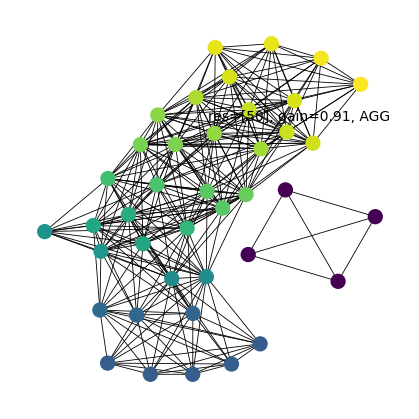

res= 45  gain= 0.94


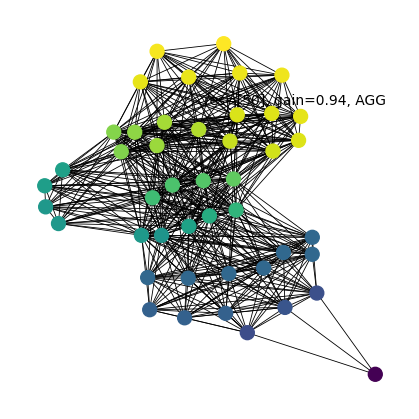

res= 48  gain= 0.85


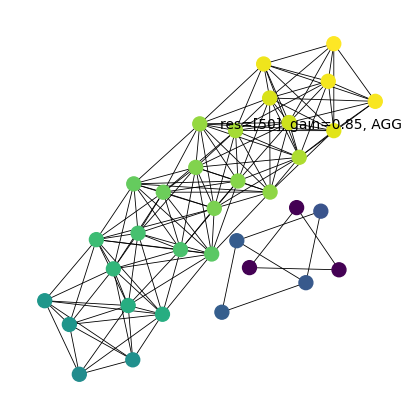

res= 48  gain= 0.88


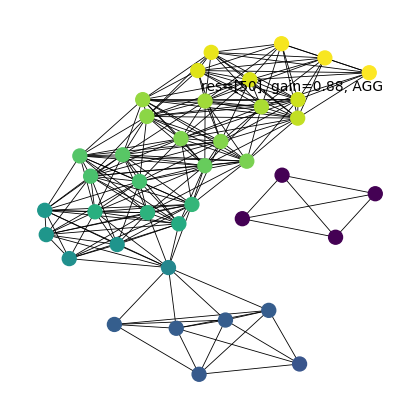

res= 48  gain= 0.91


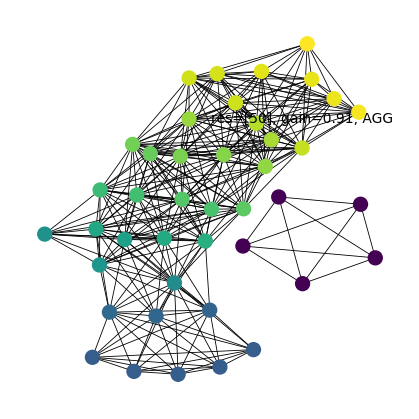

res= 48  gain= 0.94


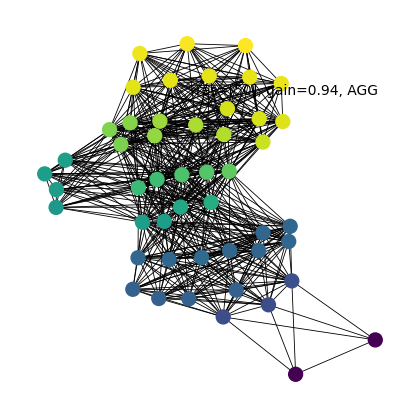

In [34]:
import warnings
warnings.filterwarnings('ignore')

#Define the filter again:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
PCA_filter = pca.fit_transform(scc_matrix)
print(PCA_filter.shape)


#Loop over different parameters:
for resolution in range(45, 50, 3):
  for gain in range(85, 95, 3):
    print("res=",resolution," gain=",gain/100)

    cover_complex = give_me_mapper(scc_matrix, resolution, gain, PCA_filter,  clustering='DBSCAN', color='ecc' )
    #Run the cover complex
    _ = cover_complex.fit(scc_matrix)

    #Save the plot 
    G = cover_complex.get_networkx()
    plt.figure(figsize=(4,4))
    nx.draw(G, pos=nx.kamada_kawai_layout(G), node_color=[cover_complex.node_info[v]["colors"][0] for v in G.nodes()], node_size=100, width=0.6)
    parameters = "res="+str(res)+', '+'gain='+str(gain/100)+', '+'AGG'
    plt.text(0, 0.5, parameters, fontsize = 10)
    plt.show()

The DBSCAN clustering results didn't give us a loop in the Mapper complex. 


#####SUMMARY:
We tried **only the first component of the PCA** as a filter using two different clustering algorithms(Agglomerative Clustering and DBSCAN) with various resolution and gain parameters.  We found one Mapper result which creates a loop within the data. The parameters of this complex are: 

*   resolution = 33, 
*   gain = 73, 
*   filter = PCA first component,  
*   clustering = Agglomerative Clustering

Now, we will use both 1st and 2nd components of PCA

###3.2.2  PCA 1st + 2nd comp. as Filter

We will test the gain and resolution parameters as well as clustering algorithms using **the first and second components of PCA together**. In this case, we are using two filters that can have a big effect on the Mapper result. The shape of the filter vector becomes (120, 2).

Before starting, I will define a function that returns the Mapper complex of a given distance matrix **with two filters**:

In [72]:
def give_me_mapper2(scc_matrix, res1, res2, gain1, gain2, filter, color, clustering ):

  if color == 'ecc':
    colors = scc_matrix.max(axis=0)
  if clustering == 'DBSCAN':
    clustering = DBSCAN(eps = 0.5, min_samples=5, metric ="cosine")
  elif clustering == 'Agg':
    clustering = AgglomerativeClustering(n_clusters=None, linkage="complete", distance_threshold=0.5, affinity="jaccard")
    #clustering = AgglomerativeClustering(n_clusters=None, linkage="complete", distance_threshold=0.5, affinity="cosine")


  #Define the Mapper complex:
  cover_complex = MapperComplex(
    input_type='distance matrix', 
    colors=colors[:,np.newaxis], mask=0,
    clustering= clustering,
    
    N=100, beta=0., C=10,
    filters=filter , 
    filter_bnds=None, 
    
    resolutions= np.array([res1, res2]),
    gains= np.array([gain1/100.0, gain2/100.0]),

    input_name="human", cover_name="coord2", color_name="coord2", verbose=True)
  return cover_complex



####1. Agglomerative Clustering / PCA(n_components=2)

Loop over different parameters and plot the Mapper result and see if there is a loop.

(120, 2)
res= 11  gain= 0.48


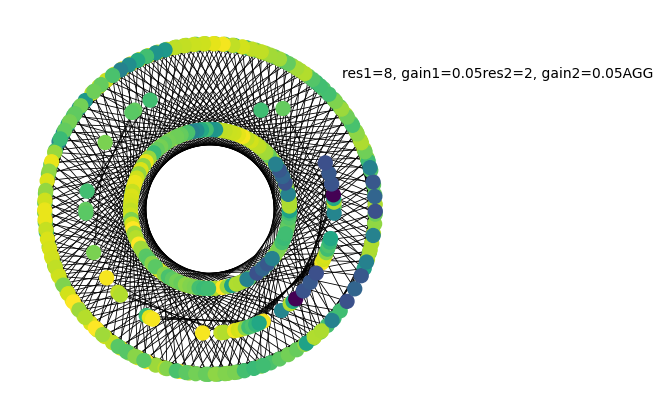

res= 11  gain= 0.48


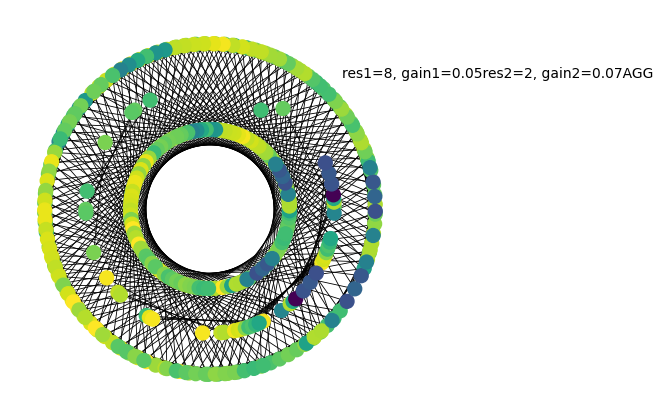

res= 11  gain= 0.48


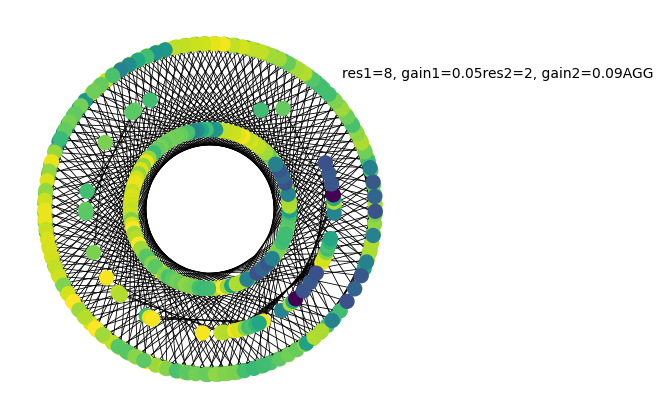

In [131]:
import warnings
warnings.filterwarnings('ignore')

#Define the filter again:
from sklearn.decomposition import PCA

#Select 2 filters:
pca = PCA(n_components=2)
PCA_filter_2 = pca.fit_transform(scc_matrix)
print(PCA_filter_2.shape)


#Loop over different parameters:
for resolution1 in range(8, 10,2):
  for gain1 in range(5,7,2):
    for resolution2 in range(2,3,1):
      for gain2 in range(5,10,2):

        print("res1=",resolution1," gain1=",gain1/100)
        print("res2=",resolution2," gain1=",gain2/100)

        cover_complex = give_me_mapper2(scc_matrix, resolution, resolution, gain, gain, PCA_filter_2, color='ecc', clustering='Agg' )
        #Run the cover complex
        _ = cover_complex.fit(scc_matrix)

        #Save the plot 
        G = cover_complex.get_networkx()
        plt.figure(figsize=(4,4))
        nx.draw(G, pos=nx.kamada_kawai_layout(G), node_color=[cover_complex.node_info[v]["colors"][0] for v in G.nodes()], node_size=100, width=0.6)
        parameters = "res1="+str(resolution1)+', '+'gain1='+str(gain1/100)+'res2='+str(resolution2)+', '+'gain2='+str(gain2/100)+'AGG'
        plt.text(0.8, 0.8, parameters, fontsize = 10)
        plt.show()



    

I tried many values for the parameters resolution1, gain1, resolution2, and gain2 but I got the result above which is a circular shape of the data points. They don't represent a loop, they are bad results. 


We couldn't find any Mapper complex that creates a loop in Agglomerative Clustering with 2 components of PCA as filters. I will try the DBSCAN as clustering algorithm in the following cell.

####2. DBSCAN / PCA(n_components=2)

(120, 2)
res1= 8  gain1= 0.05
res2= 2  gain1= 0.05


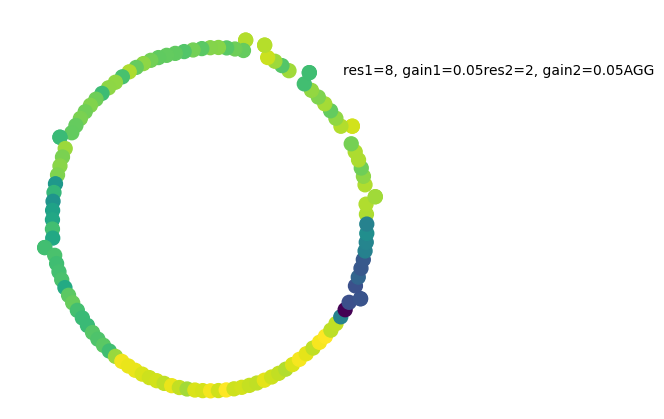

res1= 8  gain1= 0.05
res2= 2  gain1= 0.07


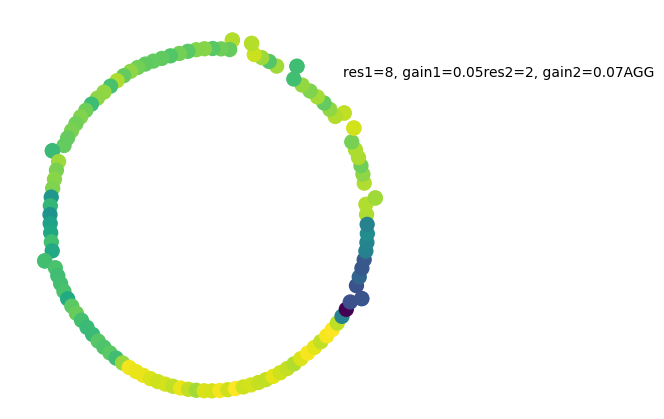

res1= 8  gain1= 0.05
res2= 2  gain1= 0.09


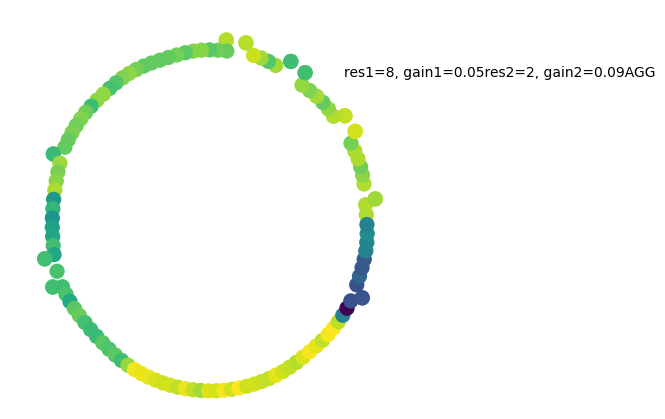

In [132]:
import warnings
warnings.filterwarnings('ignore')

#Define the filter again:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
PCA_filter_2 = pca.fit_transform(scc_matrix)
print(PCA_filter_2.shape)


#Loop over different parameters:
for resolution1 in range(8, 10,2):
  for gain1 in range(5,7,2):
    for resolution2 in range(2,3,1):
      for gain2 in range(5,10,2):

        print("res1=",resolution1," gain1=",gain1/100)
        print("res2=",resolution2," gain1=",gain2/100)

        cover_complex = give_me_mapper2(scc_matrix, resolution1, resolution2, gain1, gain2, PCA_filter_2, color='ecc', clustering='Agg' )
        #Run the cover complex
        _ = cover_complex.fit(scc_matrix)

        #Save the plot 
        G = cover_complex.get_networkx()
        plt.figure(figsize=(4,4))
        nx.draw(G, pos=nx.kamada_kawai_layout(G), node_color=[cover_complex.node_info[v]["colors"][0] for v in G.nodes()], node_size=100, width=0.6)
        parameters = "res1="+str(resolution1)+', '+'gain1='+str(gain1/100)+'res2='+str(resolution2)+', '+'gain2='+str(gain2/100)+', AGG'
        plt.text(0.8, 0.8, parameters, fontsize = 10)
        plt.show()



I tried many values for the parameters resolution1, gain1, resolution2, and gain2 but again I received the circular shape of the data points as shown above. They are again insufficient results. 


We couldn't find any Mapper complex that creates a loop in DBSCAN and Agglomerative Clustering algorithms using the **2 components of PCA as filters**. Using the two PCA components somehow mapped the data points into a circular shape where they didn't create a topological complex. 

#5. Coloring with features

We found a Mapper complex that has a loop inside with parameters:  

*   resolution = 33, 
*   gain = 73, 
*   **filter = only the first component of PCA**,  
*   clustering = Agglomerative Clustering

Visualize it and observe the loop:

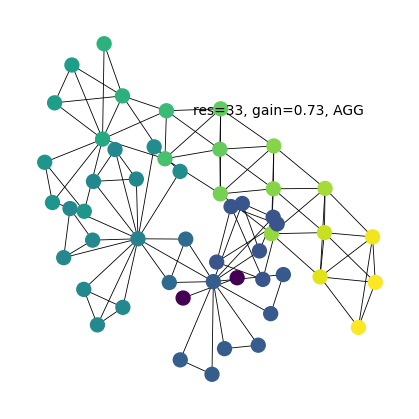

In [87]:
#Define the filter (again)
pca = PCA(n_components=1)
PCA_filter = pca.fit_transform(scc_matrix)

cover_complex = give_me_mapper(scc_matrix, 33, 73, PCA_filter,  clustering='Agg', color='ecc' )
#Run the cover complex
_ = cover_complex.fit(scc_matrix)

#Save the plot 
G = cover_complex.get_networkx()
plt.figure(figsize=(4,4))
nx.draw(G, pos=nx.kamada_kawai_layout(G), node_color=[cover_complex.node_info[v]["colors"][0] for v in G.nodes()], node_size=100, width=0.6)
parameters = "res="+str(33)+', '+'gain='+str(73/100)+', '+'AGG'
plt.text(0, 0.5, parameters, fontsize = 10)
plt.show()

Now, We will color this complex with with other features such as:

*   mean_insu
*   f_near_band
*   f_mitotic_band 
*   repli_score

These features are inside the features.txt file. Load that file:


In [89]:
import pandas as pd

features = pd.read_csv("/content/drive/MyDrive/Geometric_methods_PROJECT/schic/features.txt", sep="\t")
features['cell_name'] = features['cell_nm'].str.replace('_', '.')

features.head(2)

batch_id batch_name  cond cell_nm  f_no_digestion  mean_f_fend_dup  \
0        11  1CDU_2312  1CDU  1CDU_1        0.234231         0.024752   
1        11  1CDU_2312  1CDU  1CDU_2        0.216173         0.017595   

   max_chrom_cov_abber   f_trans  trans_align  total_contacts  ...  mean_insu  \
0             0.278872  0.113668     0.234231           83348  ...   2.580145   
1             0.378858  0.094847     0.204004          214629  ...   2.551423   

   loop_enr_EE  loop_enr_LL    ord    group  f_mitotic_band  f_near_band  \
0     0.415037     0.397335  846.0  early-S        0.124002     0.699160   
1     0.546692     0.621488  501.0  early-S        0.132541     0.671156   

        far_mu  repli_score  cell_name  
0  26099026.25     1.210399     1CDU.1  
1  30249812.50     1.034900     1CDU.2  

[2 rows x 23 columns]


When we load the Hi-C contact maps we also saved the file names of them in a list called "contact_map_names":

In [90]:
#Get the first 120 matrix names
contact_map_names = contact_map_names[:120]

print(contact_map_names)
print(len(contact_map_names))

['1CDX2.56', '1CDX1.85', '1CDX1.136', '1CDX2.101', '1CDX4.474', '1CDX2.333', '1CDX3.358', '1CDX1.71', '1CDX1.304', '1CDX4.222', '1CDX3.155', '1CDX1.2', '1CDX2.367', '1CDX4.282', '1CDX1.162', '1CDX4.276', '1CDX2.155', '1CDX1.196', '1CDX3.333', '1CDX2.393', '1CDX2.394', '1CDX1.25', '1CDX3.334', '1CDX1.357', '1CDX1.191', '1CDX1.5', '1CDX1.165', '1CDX4.285', '1CDX3.106', '1CDX4.411', '1CDX1.22', '1CDX4.418', '1CDX3.302', '1CDX1.153', '1CDX4.247', '1CDX3.1', '1CDX2.164', '1CDX2.356', '1CDX4.278', '1CDX1.392', '1CDX2.33', '1CDX2.163', '1CDX1.14', '1CDX1.395', '1CDX3.6', '1CDX3.305', '1CDX2.197', '1CDX3.137', '1CDX3.108', '1CDX1.366', '1CDX2.34', '1CDX1.154', '1CDX1.13', '1CDX1.108', '1CDX4.416', '1CDX1.305', '1CDX4.475', '1CDX2.57', '1CDX3.392', '1CDX3.154', '1CDX1.77', '1CDX4.223', '1CDX3.366', '1CDX2.332', '1CDX1.83', '1CDX2.335', '1CDX4.486', '1CDX2.107', '1CDX3.368', '1CDX4.472', '1CDX3.153', '1CDX2.92', '1CDX3.395', '1CDX4.224', '1CDX1.41', '1CDX2.303', '1CDX2.131', '1CDX3.191', '1CDX1.

The list "contact_map_names" contains the names of the 120 matrices that we used in this project. I will match these names with the "cell_names" column in the features data frame to extract only 120 contact maps' features:

In [91]:
d = {'cell_name': contact_map_names}
df = pd.DataFrame(data=d)
df.head(3)

#Inner-join the cell_names to extract 120 matrices features:
features_subset = df.merge(features, on='cell_name')
features_subset.head(3)

cell_name  batch_id  batch_name    cond    cell_nm  f_no_digestion  \
0   1CDX2.56        21  1CDX2_3197  1CD_eS   1CDX2_56        0.363142   
1   1CDX1.85        19  1CDX1_3158  1CD_G1   1CDX1_85        0.340796   
2  1CDX1.136        19  1CDX1_3158  1CD_G1  1CDX1_136        0.329183   

   mean_f_fend_dup  max_chrom_cov_abber   f_trans  trans_align  ...  \
0         0.027419             0.181989  0.105151     0.268008  ...   
1         0.036533             0.851507  0.039270     0.317296  ...   
2         0.036555             0.180859  0.062708     0.282018  ...   

   passed_qc  mean_insu  loop_enr_EE  loop_enr_LL    ord    group  \
0          1   2.594467     0.022026     1.097169  760.0  early-S   
1          1   2.352409     0.769994     0.729352  200.0       G1   
2          1   2.483102     0.913585     0.633872  313.0       G1   

   f_mitotic_band  f_near_band       far_mu  repli_score  
0        0.115892     0.703989  29365912.10     1.148372  
1        0.154834     0.556334  27762597.22     1.137121  
2        0.143203     0.614327  27246148.94     1.079178  

[3 rows x 23 columns]

In [92]:
features_subset.shape

(120, 23)

Now we can define the color vectors for the Mapper complex


In [93]:
mean_insu_filter = features_subset['mean_insu']
f_near_band_filter = features_subset['f_near_band']
f_mitotic_band_filter = features_subset['f_mitotic_band']
repli_score_filter = features_subset['repli_score']


##5.1 Coloring with 'mean_insu'

Call the "give_me_mapper" function with color_vector = mean_insu_filter.

In [96]:
#give_me_mapper(scc_matrix, resolution, gain, filter,  clustering, color=None, color_vector = None )

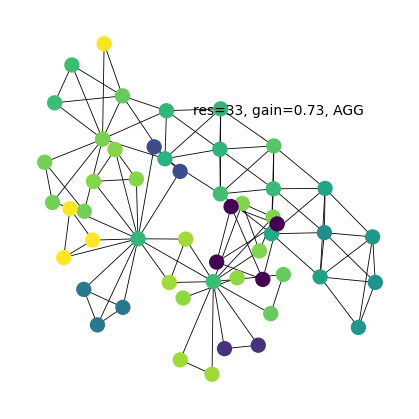

In [99]:
#Define the filter (again)
pca = PCA(n_components=1)
PCA_filter = pca.fit_transform(scc_matrix)

cover_complex = give_me_mapper(scc_matrix, 33, 73, PCA_filter,  clustering='Agg', color_vector = mean_insu_filter )
#Run the cover complex
_ = cover_complex.fit(scc_matrix)

#Save the plot 
G = cover_complex.get_networkx()
plt.figure(figsize=(4,4))
nx.draw(G, pos=nx.kamada_kawai_layout(G), node_color=[cover_complex.node_info[v]["colors"][0] for v in G.nodes()], node_size=100, width=0.6)
parameters = "res="+str(33)+', '+'gain='+str(73/100)+', '+'AGG'
plt.text(0, 0.5, parameters, fontsize = 10)
plt.show()

##5.2 Coloring with 'f_near_band_filter'

Call the "give_me_mapper" function with color_vector = f_near_band_filter.

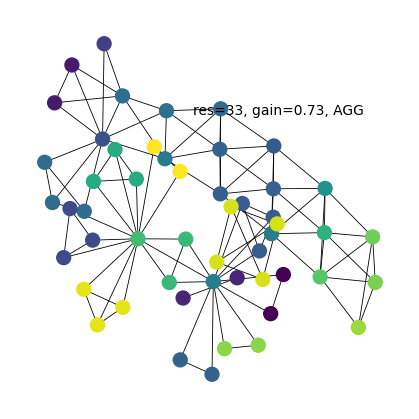

In [100]:
#Define the filter (again)
pca = PCA(n_components=1)
PCA_filter = pca.fit_transform(scc_matrix)

cover_complex = give_me_mapper(scc_matrix, 33, 73, PCA_filter,  clustering='Agg', color_vector = f_near_band_filter )
#Run the cover complex
_ = cover_complex.fit(scc_matrix)

#Save the plot 
G = cover_complex.get_networkx()
plt.figure(figsize=(4,4))
nx.draw(G, pos=nx.kamada_kawai_layout(G), node_color=[cover_complex.node_info[v]["colors"][0] for v in G.nodes()], node_size=100, width=0.6)
parameters = "res="+str(33)+', '+'gain='+str(73/100)+', '+'AGG'
plt.text(0, 0.5, parameters, fontsize = 10)
plt.show()

##5.3 Coloring with 'f_mitotic_band_filter'

Call the "give_me_mapper" function with color_vector = f_mitotic_band_filter.

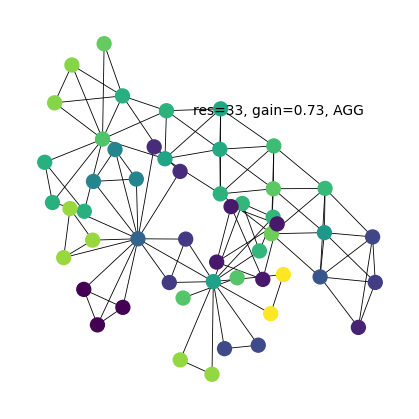

In [101]:
#Define the filter (again)
pca = PCA(n_components=1)
PCA_filter = pca.fit_transform(scc_matrix)

cover_complex = give_me_mapper(scc_matrix, 33, 73, PCA_filter,  clustering='Agg', color_vector = f_mitotic_band_filter )
#Run the cover complex
_ = cover_complex.fit(scc_matrix)

#Save the plot 
G = cover_complex.get_networkx()
plt.figure(figsize=(4,4))
nx.draw(G, pos=nx.kamada_kawai_layout(G), node_color=[cover_complex.node_info[v]["colors"][0] for v in G.nodes()], node_size=100, width=0.6)
parameters = "res="+str(33)+', '+'gain='+str(73/100)+', '+'AGG'
plt.text(0, 0.5, parameters, fontsize = 10)
plt.show()

##5.4 Coloring with 'repli_score_filter'

Call the "give_me_mapper" function with color_vector = repli_score_filter.

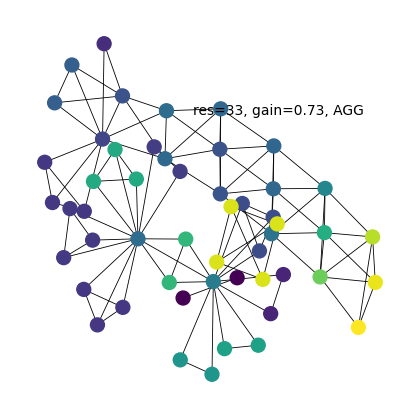

In [102]:
#Define the filter (again)
pca = PCA(n_components=1)
PCA_filter = pca.fit_transform(scc_matrix)

cover_complex = give_me_mapper(scc_matrix, 33, 73, PCA_filter,  clustering='Agg', color_vector = repli_score_filter )
#Run the cover complex
_ = cover_complex.fit(scc_matrix)

#Save the plot 
G = cover_complex.get_networkx()
plt.figure(figsize=(4,4))
nx.draw(G, pos=nx.kamada_kawai_layout(G), node_color=[cover_complex.node_info[v]["colors"][0] for v in G.nodes()], node_size=100, width=0.6)
parameters = "res="+str(33)+', '+'gain='+str(73/100)+', '+'AGG'
plt.text(0, 0.5, parameters, fontsize = 10)
plt.show()

For each biological marker, the distribution of values seems a little consistent.

#6. Investigate the Topological features

If our Mapper complex has a loop, then that loop may represent a topological feature. We can visualize the topological features of our complex using GUDHI. 

In [103]:
cover_complex.data = scc_matrix

In [105]:
dgm, bnd = compute_topological_features(cover_complex, threshold=0.)
print(bnd)
print(len(bnd))

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 31, 34, 50], [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 37, 39, 40, 41, 43, 44, 46, 48, 49, 51], [35, 36], [38, 42, 45, 47], [1, 15, 0], [2, 15, 0], [1, 3, 0], [2, 3, 0], [4, 6, 3], [5, 6, 3], [7, 14, 6], [13, 14, 6], [7, 12, 14], [8, 12, 14], [9, 12, 14], [13, 12, 14], [8, 9, 14], [8, 11, 9], [10, 11, 9], [16, 50, 11], [31, 50, 11], [10, 34, 11], [17, 34, 11], [16, 31, 11], [10, 18, 11], [10, 17, 11], [8, 10, 9], [13, 8, 14], [5, 13, 6], [7, 13, 6], [4, 7, 6], [5, 7, 6], [2, 5, 3], [4, 5, 3], [1, 4, 3], [2, 4, 3], [1, 2, 0], [23, 48, 19], [20, 51, 23], [32, 51, 23], [21, 49, 23], [33, 49, 23], [24, 37, 23], [27, 37, 23], [41, 46, 37], [44, 46, 37], [41, 44, 37], [39, 43, 37], [28, 40, 37], [25, 29, 37], [21, 33, 23], [20, 32, 23], [22, 30, 23], [26, 30, 23], [24, 27, 23], [22, 26, 23], [42, 47, 38], [45, 47, 38], [42, 45, 38], [50, 16, 31, 11], [14, 13, 7, 6, 12, 8], [48, 19, 23], [21, 49, 33, 23], [26, 

"bnd" is a list of topological features. If three data points creates a community then it is considered as a topological feature that are stored in "bnd". There are 70 topological features of our Mapper complex. We can eliminate some the features by putting a threshold. If we set a threshold as 4, then we can eliminate topological features consist of only 3 data points. The following function omits features whose number of data points < 4.

In [107]:
def get_features_that_makes_a_community(min_num_points_in_a_comm, bnd):
  bnd_temp= []  
  #Detect communities(topological feautes) that have # of points >= min_num_points_in_a_community
  for i in range(len(bnd)):
    if len(bnd[i]) >= 4:
      bnd_temp.append(bnd[i])  
  return bnd_temp


#Our new topological features
bnd_temp = get_features_that_makes_a_community(min_num_points_in_a_comm,bnd)

In [108]:
print(bnd_temp)
print(len(bnd_temp))

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 31, 34, 50], [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 37, 39, 40, 41, 43, 44, 46, 48, 49, 51], [38, 42, 45, 47], [50, 16, 31, 11], [14, 13, 7, 6, 12, 8], [21, 49, 33, 23], [26, 22, 30, 23, 37], [41, 46, 44, 37], [32, 20, 51, 23], [9, 8, 12, 7]]
10


We have 10 topological features now.

Now let's visualize the new topological features:

0 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 31, 34, 50]
1 [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 37, 39, 40, 41, 43, 44, 46, 48, 49, 51]
2 [38, 42, 45, 47]
3 [50, 16, 31, 11]
4 [14, 13, 7, 6, 12, 8]
5 [21, 49, 33, 23]
6 [26, 22, 30, 23, 37]
7 [41, 46, 44, 37]
8 [32, 20, 51, 23]
9 [9, 8, 12, 7]


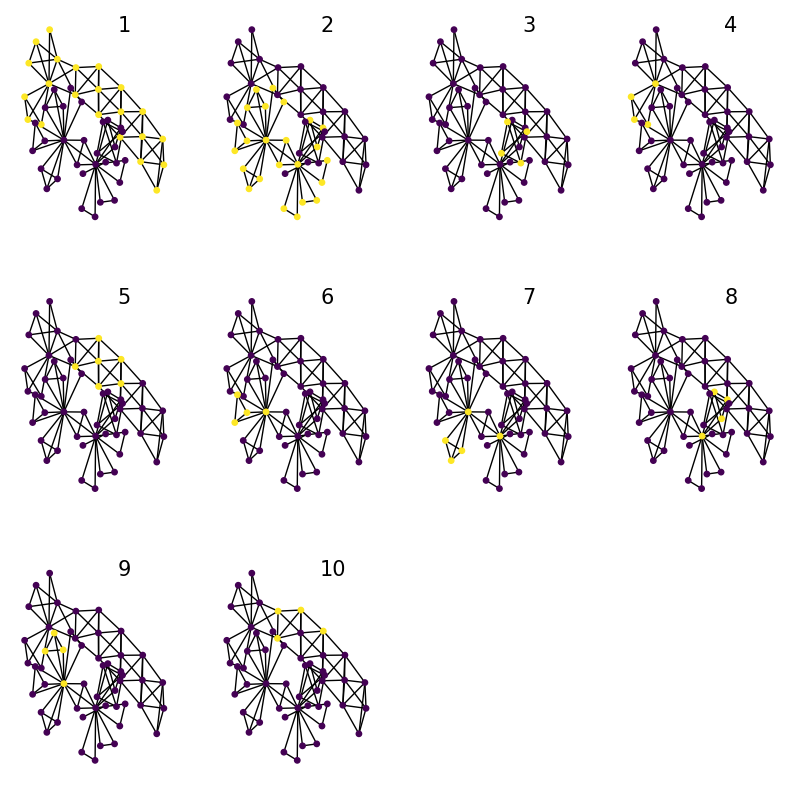

In [117]:
G = cover_complex.get_networkx()
plt.figure(figsize=(10,10))
for idx, bd in enumerate(bnd_temp):
    print(idx,bd)
    #plt.subplot(1,len(bnd),idx+1)
    plt.subplot(3,4,idx+1)
    nx.draw(G, pos=nx.kamada_kawai_layout(G), 
            node_color=[1 if node in bd else 0 for node in G.nodes()], node_size=15)
    plt.text(0.4, 0.8, idx+1, fontsize = 15)

plt.savefig("sss.png")
plt.show()

The topological features are represented in yellow. We can see that in the 2nd image, the topological feature could validate the loop.

#7. Bootstrapping

Quantify the cell cycle statistical robustness (whether it is an artifact of computation or not) by
bootstrapping the data: subsample the dataset (with replacement) many times, and compute the
fraction of times in which the cell cycle is detected.

In [118]:
cover_complex

MapperComplex(C=10,
              clustering=AgglomerativeClustering(affinity='jaccard',
                                                 distance_threshold=0.5,
                                                 linkage='single',
                                                 n_clusters=None),
              color_name='coord2',
              colors=array([[1.14837211],
       [1.13712117],
       [1.07917839],
       [1.31021267],
       [1.14245231],
       [1.14436922],
       [1.27787336],
       [1.10147698],
       [1.09049277],
       [1.22085655],
       [1.21512224],
       [1.05112576],
       [1.24101779],
       [1.31840978],
       [1.0...
       [-8.75900630e-01],
       [-3.26100217e-01],
       [ 2.82409324e-01],
       [-8.56970207e-01],
       [-2.66829609e-01],
       [-9.05521067e-01],
       [-2.23295325e-01],
       [ 5.57692223e-01],
       [ 2.67013460e-02],
       [ 6.22388028e-01],
       [-9.15819617e-01],
       [-1.11465407e+00],
       [-1.03381364e+00],
       [-7.98047481e-02]]),
              gains=array([0.73]), input_name='human',
              input_type='distance matrix', resolutions=array([33]),
              verbose=True)

We will test the robust topological features by bootstrapping, and select those associated to 95% confidence.

In [119]:
bootstrap_topological_features(cover_complex, 100)

0th iteration
1th iteration
2th iteration
3th iteration
4th iteration
5th iteration
6th iteration
7th iteration
8th iteration
9th iteration
10th iteration
11th iteration
12th iteration
13th iteration
14th iteration
15th iteration
16th iteration
17th iteration
18th iteration
19th iteration
20th iteration
21th iteration
22th iteration
23th iteration
24th iteration
25th iteration
26th iteration
27th iteration
28th iteration
29th iteration
30th iteration
31th iteration
32th iteration
33th iteration
34th iteration
35th iteration
36th iteration
37th iteration
38th iteration
39th iteration
40th iteration
41th iteration
42th iteration
43th iteration
44th iteration
45th iteration
46th iteration
47th iteration
48th iteration
49th iteration
50th iteration
51th iteration
52th iteration
53th iteration
54th iteration
55th iteration
56th iteration
57th iteration
58th iteration
59th iteration
60th iteration
61th iteration
62th iteration
63th iteration
64th iteration
65th iteration
66th iteration
67th 

In [121]:
dist = get_distance_from_confidence_level(cover_complex, .95)
print(dist)

0.06600746099999988


In [123]:
bnd_boot = [b for idx, b in enumerate(bnd) if np.abs(.5 * (dgm[idx][1][1]-dgm[idx][1][0])) >= dist]
print(bnd_boot)
print(len(bnd_boot))

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 31, 34, 50], [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 37, 39, 40, 41, 43, 44, 46, 48, 49, 51]]
2


Visualize the bootstrapped features:

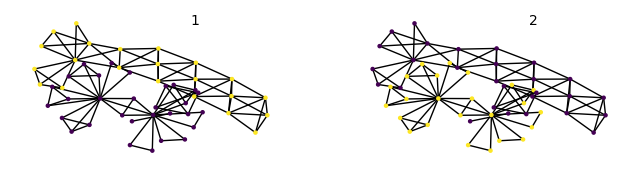

In [127]:
G = cover_complex.get_networkx()
plt.figure(figsize=(8,2))
for idx, bd in enumerate(bnd_boot):
    plt.subplot(1,len(bnd_boot),idx+1)
    nx.draw(G, pos=nx.kamada_kawai_layout(G), 
            node_color=[1 if node in bd else 0 for node in G.nodes()], node_size=5)
    plt.text(0.4, 0.8, idx+1, fontsize = 10)
plt.show()

As we can see in the second image, the topological feature that could validate the loop didn't disappear with bootstrapping. We can conclude with 95% confidence that the loop is not a noise or artifact, instead, it is a biological mark of the SCC distance matrix that is built by using the single-cell Hi-C contact maps.


#8. Compare and discuss your results with directly running dimensionality reduction on the raw contact maps.

Using the SCC matrix as a similarity measure between Hi-C contact maps helped us to successfully group cells and created a loop. Also, we used a classical dimension reduction method such as PCA, which guides the Mapper complex computation as a filter. Using only the first component of PCA gave us a successful result that has a loop. However, using both of the components of PCA didn't work well.


#9. Conclusion

In this project, I analyzed the single-cell Hi-C contact maps. A Hi-C contact map is a pairwise distance matrix that encodes how chromatin is folded in the nucleus of a cell: each row and column
of the matrix represents a small DNA window, and each entry in the matrix is the spatial distance between these windows in the nucleus. I measured the Stratum-adjusted Correlation Coefficients
(SCC) value between 120 contact maps and created an SCC similarity matrix of shape (120, 120). Then various Mapper parameters were tested on the matrix to find a cycle cell(loop) such as resolution, gain, clustering algorithm, and filter. As a filter, the first and second component of PCA was used. The Mapper result has a cell cycle extracted by using the following parameters: resolution = 33, gain = 73, filter = PCA first component, clustering = Agglomerative Clustering. The final Mapper complex was colored by different biomarkers such as mean_insu, f_near_band, f_mitotic_band, and repli_score. I also tested the robustness of the cell cycle by bootstrapping the data. The cell cycle appeared to be robust against noise and artifact and became a statistically significant topological feature. 

